In this notebook, we reproduce the Bayesian model introduced in the paper “Reconstruction of plant–pollinator networks from observational data” by Young, Valdovinos, and Newman. The model infers the underlying structure of a plant–pollinator network from observational data—specifically, from the number of visits observed between different plant and pollinator species.

Rather than relying only on raw counts, this approach treats the data as samples from a hidden interaction structure, accounting for species’ abundances, observation effort, and the possibility of preferred interactions. The model uses a Poisson distribution to describe visit counts and a Bayesian framework to infer the most likely structure and parameters. This allows us not only to estimate who interacts with whom, but also to quantify uncertainty and test model fit using simulated data.

**Goal of the Model**

We want to understand the true ecological network: which pollinators actually interact with which plants, even if some interactions were missed or under-sampled. Instead of taking the visit counts at face value, we ask:

“What underlying network structure would most likely explain the visits we observed?”



In [1]:
!pip install cmdstanpy

In [2]:
from cmdstanpy import install_cmdstan
install_cmdstan()

CmdStan install directory: /Users/tatimein/.cmdstan
CmdStan version 2.36.0 already installed
Test model compilation


True

In [3]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import scipy.stats as stats
import networkx as nx
import os
from pathlib import Path
from io import StringIO
from scipy.stats import poisson
from scipy.stats import bernoulli
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from cmdstanpy import cmdstan_path
from cmdstanpy import CmdStanModel
from pathlib import Path

# Set default working directory
CODING_DIR = Path("~/Desktop/Coding").expanduser()
CODING_DIR.mkdir(parents=True, exist_ok=True)

# Define the network name and build API URL
network_name = "M_PL_019"
base_url = "https://www.web-of-life.es/"
endpoint = f"get_networks.php?network_name={network_name}"
json_url = base_url + endpoint

# Fetch and parse the data
response = requests.get(json_url)
response.raise_for_status()
data = response.json()
df = pd.DataFrame(data)

# Preview the raw long-format data
print("First few rows of the raw network data (long format):")
print(df.head())

# Pivot to plant (rows) × pollinator (columns) visitation matrix
visit_matrix = df.pivot_table(
    index="species1",
    columns="species2",
    values="connection_strength",
    aggfunc="sum",
    fill_value=0
)

# Rename axes and ensure all values are integers
visit_matrix.index.name = "Plant"
visit_matrix.columns.name = "Pollinator"
visit_matrix = visit_matrix.apply(pd.to_numeric, errors="coerce").fillna(0).astype(int)

# Confirm data integrity
print("\nColumn data types after conversion:")
print(visit_matrix.dtypes.value_counts())

print("\nVisit count matrix (plants × pollinators):")
display(visit_matrix)

total_interactions = visit_matrix.values.sum()
print(f"\nTotal observed interactions: {total_interactions}")

#Save matrix to Desktop/Coding
visit_matrix.to_csv(CODING_DIR / f"{network_name}_matrix.csv")

First few rows of the raw network data (long format):
  network_name                species1                species2  \
0     M_PL_019  Craspedia sp1 M_PL_019         Eristalis tenax   
1     M_PL_019      Pimelea ligustrina         Eristalis tenax   
2     M_PL_019      Pimelea ligustrina          Apis mellifera   
3     M_PL_019       Orites lancifolia       Calliphora stygia   
4     M_PL_019   Microseris lanceolata  Hylaeus semipersonatus   

  connection_strength  
0                   2  
1                   3  
2                   3  
3                   2  
4                   1  

Column data types after conversion:
int64    85
Name: count, dtype: int64

Visit count matrix (plants × pollinators):


Pollinator,Alophera sp1 M_PL_019,Apis mellifera,Calliphora fulvicoxa,Calliphora hilli,Calliphora sp1 M_PL_019,Calliphora sp2 M_PL_019,Calliphora sp3 M_PL_019,Calliphora stygia,Chaetophthalamus dorsalis,Chloromerus sp1 M_PL_019,...,Tachinidae sp1 M_PL_019,Tachinidae sp2 M_PL_019,Tachinidae sp3 M_PL_019,Tachinidae sp4 M_PL_019,Tapeigaster nigricornis,Tephritis sp1 M_PL_019,Tephritis sp2 M_PL_019,Therevidae sp1 M_PL_019,Tiphiidae sp1 M_PL_019,Villa sp1 M_PL_019
Plant,,,,,,,,,,,,,,,,,,,,,
Achillea millefolium,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aciphylla glacialis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
Aciphylla simplicifolia,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Asperula gunnii,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Baeckia gunniana,0,0,0,0,0,5,0,0,0,0,...,1,1,0,2,1,0,0,0,0,0
Brachycome scapiformis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Brachycome scapigera,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Brachycome sp1 M_PL_019,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Brachycome stolonifera,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Total observed interactions: 1314


The first step in the model is to calculate μᵢⱼ, which represents the expected number of visits from pollinator j to plant i. This is not the number we actually observed—it’s the number the model thinks we should expect if we knew the true interaction structure and other factors like abundance and observation effort.

The formula is:

μᵢⱼ = C × σᵢ × τⱼ × (1 + r × Bᵢⱼ)

Each part of this equation plays a specific role:


*   C is a constant that captures how much time or effort was spent observing visits. If observers spent more time watching, they’re likely to see more visits overall, so C would be higher.
*   σᵢ (sigma) represents the relative abundance or visibility of plant i. A very common or noticeable plant would have a higher σᵢ, meaning it naturally gets more visits.
*   τⱼ (tau) is the relative abundance or visibility of pollinator j. A very active or common pollinator will also show up more often.
*   The product C × σᵢ × τⱼ gives a kind of baseline expectation for how many visits would occur between this pair if there were no strong preference.
*   The last part, (1 + r × Bᵢⱼ), adjusts that baseline:
    *   If Bᵢⱼ = 0, meaning pollinator j doesn’t actually prefer plant i, this becomes just 1 (so the visit count stays at the baseline).
    *   If Bᵢⱼ = 1, meaning a true preferred interaction exists, the term becomes 1 + r, so the expected visits are boosted by a factor of r.

In simple terms:

This equation combines how likely a pair is to interact by chance (based on their abundance and sampling effort) with a boost if they are a true, preferred match.

It’s our first key step in modeling the network—not by assuming visits = interactions, but by asking:

“Given what we know about this pair, how many visits would we expect if they’re truly connected—or not?”

Thus, **Equation (1) — Mean number of visits (μᵢⱼ)**

From the article:

μᵢⱼ = C × σᵢ × τⱼ × (1 + r × Bᵢⱼ)

Where:
*   μᵢⱼ is the expected number of visits from pollinator j to plant i
*   C is a constant related to sampling effort
*   σᵢ is abundance (or visibility) of plant i
*   τⱼ is abundance (or visibility) of pollinator j
*   r is the interaction preference multiplier
*   Bᵢⱼ is the true (hidden) interaction (1 if a preferred interaction exists, else 0)

In [4]:
def compute_mu(C, sigma, tau, r, B):
    """
    Computes the matrix of expected visit counts (μ) using Equation (1):
    μᵢⱼ = C * σᵢ * τⱼ * (1 + r * Bᵢⱼ)

    Parameters:
    - C: float, sampling effort
    - sigma: 1D array of plant abundances (length n_plants)
    - tau: 1D array of pollinator abundances (length n_pollinators)
    - r: float, interaction preference multiplier
    - B: 2D binary array (n_plants x n_pollinators) of true interactions

    Returns:
    - mu: 2D numpy array (n_plants x n_pollinators) of expected visit counts
    """
    sigma = np.asarray(sigma, dtype=float).reshape(-1, 1)  # column vector
    tau = np.asarray(tau, dtype=float).reshape(1, -1)      # row vector
    B = np.asarray(B, dtype=int)
    if B.shape != (sigma.shape[0], tau.shape[1]):
       raise ValueError("Shape mismatch: B should be of shape (len(sigma), len(tau))")

    if not ((B == 0) | (B == 1)).all():
       raise ValueError("Matrix B must be binary (only 0s and 1s).")

    mu = C * sigma * tau * (1 + r * B)
    return mu

Now that we’ve defined μᵢⱼ—the expected number of visits from pollinator j to plant i—we can move on to describing how actual observations are modeled. In reality, we don’t always observe the exact expected number of visits. Even if the expected value is, say, 4.5 visits, we might observe 3, 5, or even 0, just due to chance. To capture this natural randomness in ecological observations, the model assumes that the number of observed visits Mᵢⱼ follows a Poisson distribution with mean μᵢⱼ.

The Poisson distribution is commonly used to model counts of rare or random events over fixed intervals, such as pollinator visits during a sampling period. So, in **Equation (2), the model defines the probability of observing exactly Mᵢⱼ visits as:**

P(Mᵢⱼ | μᵢⱼ) = (μᵢⱼ^Mᵢⱼ / Mᵢⱼ!) × e^(−μᵢⱼ)

To understand how this equation works, let’s break down its components:
*   μᵢⱼ^Mᵢⱼ means we raise the expected number of visits to the power of the observed count. This reflects the idea that the more visits we actually see, the more weight we place on larger expected values.
*   Mᵢⱼ! (Mᵢⱼ factorial) scales the result to account for how many different ways we could have arranged that number of visits. It ensures the probability is properly normalized.
*   e^(−μᵢⱼ) is an exponential decay term that ensures the total probability sums correctly across all possible visit counts. It essentially penalizes high expected values unless there is enough observed data to support them.

Together, these components provide a mathematically sound way to evaluate how likely it is to observe a given count Mᵢⱼ, assuming μᵢⱼ is correct. In other words, Equation (2) connects the model’s internal predictions to real-world data, forming the foundation for evaluating how well different combinations of parameters and network structures explain what we actually observed.

In [5]:
# Get the number of plants and pollinators from the long-format data
plants = sorted(df["species1"].unique())
pollinators = sorted(df["species2"].unique())

n_plants = len(plants)
n_pollinators = len(pollinators)

# Set test values for model parameters
C = 100.0  # Example sampling effort constant
r = 10.0   # Example interaction preference multiplier

# Uniform abundances and full interaction matrix for initial test
sigma = np.ones(n_plants) / n_plants
tau = np.ones(n_pollinators) / n_pollinators
B = np.ones((n_plants, n_pollinators), dtype=int)

# Compute expected visit matrix μ using Equation (1)
mu = compute_mu(C, sigma, tau, r, B)

# Draw one posterior predictive sample of visit counts from Poisson(μᵢⱼ)
# This simulates what an observation might look like under the model
M_tilde = poisson(mu).rvs()

# Define the Poisson log-likelihood function (Equation 2)
# We'll use this later to compute model fit under Poisson assumptions
def poisson_log_likelihood(M, mu):
    """
    Compute the log-likelihood of observed counts M given expected values mu,
    assuming Poisson-distributed visit events.

    Parameters:
        M (2D array): Observed visit counts (plants × pollinators)
        mu (2D array): Expected visit counts (same shape as M)

    Returns:
        float: Total log-likelihood across all species pairs
    """
    M = np.asarray(M)
    mu = np.clip(np.asarray(mu), 1e-10, None)  # Avoid log(0)

    if M.shape != mu.shape:
        raise ValueError("Observed and expected matrices must have the same shape.")

    return np.sum(poisson.logpmf(M, mu))

print("Example of a simulated visit matrix (posterior predictive):")
print(M_tilde[:5, :5])  # Show a small slice

Example of a simulated visit matrix (posterior predictive):
[[0 1 0 1 1]
 [0 0 0 1 1]
 [0 0 1 1 0]
 [0 0 0 0 1]
 [0 0 0 0 2]]


When working with probabilistic models like this one, it’s common to compute the likelihood of the data given the model parameters. However, multiplying many small probabilities together—like the individual Poisson probabilities for each plant–pollinator pair—can quickly lead to numerical instability. The result might be so small that the computer rounds it down to zero, even if it’s mathematically meaningful. To avoid this issue, we use the log-likelihood instead. Taking the logarithm of each probability transforms the product of many small numbers into a sum of log-probabilities, which is much more stable and easier for computers to handle. This approach is also mathematically convenient: later in the Bayesian inference steps, we’ll be maximizing or sampling from the posterior distribution, which depends on the log-likelihood. So switching to the log form early on makes the entire workflow smoother and more robust.

Now that we’ve defined the probability of observing a specific number of visits for a single plant–pollinator pair (Equation 2), we can extend this idea to the entire dataset. That’s what **Equation (3) does: it calculates the total likelihood of observing all the values in the visit matrix M, given a proposed interaction network B and a set of parameters θ (which includes C, r, σ, and τ).** The model assumes that each interaction is independent, so the total likelihood is the product of the individual Poisson probabilities across all plant–pollinator pairs (i, j).

To understand this equation, it helps to break it down into its components:
*   The term C × σᵢ × τⱼ × (1 + r × Bᵢⱼ) gives the expected number of visits μᵢⱼ for a given pair, as we saw in Equation (1).
*   μᵢⱼ^Mᵢⱼ / Mᵢⱼ! comes from the Poisson distribution and gives the likelihood of observing exactly Mᵢⱼ visits.
*   The factor e^(−μᵢⱼ) accounts for the probability of not seeing more visits than expected.

When we multiply all these probabilities together for every pair (i, j), we get a single number that tells us how well the current network and parameters explain the entire observed dataset. In practice, we work with the log of this likelihood to improve numerical stability, which turns the product into a sum. This summed log-likelihood is what we’ll use to compare different possible network structures and guide the Bayesian inference process.

In [6]:
def compute_log_likelihood(M, C, sigma, tau, r, B):
    """
    Computes the total log-likelihood of the observed visit matrix M
    under the Bayesian plant-pollinator model (Equation 3),
    given parameters and a binary interaction matrix B.

    Parameters:
        M (2D array): Observed visit counts (shape: n_plants × n_pollinators)
        C (float): Sampling effort parameter
        sigma (1D array): Relative abundances of plant species
        tau (1D array): Relative abundances of pollinator species
        r (float): Interaction preference multiplier
        B (2D binary array): Interaction matrix (same shape as M)

    Returns:
        float: Total log-likelihood of M under the given parameters and network
    """
    M = np.asarray(M)
    B = np.asarray(B, dtype=int)

    if M.shape != B.shape:
        raise ValueError("Observed matrix M and interaction matrix B must have the same shape.")
    if not ((B == 0) | (B == 1)).all():
        raise ValueError("Matrix B must be binary (containing only 0s and 1s).")

    mu = compute_mu(C, sigma, tau, r, B)
    mu = np.clip(mu, 1e-10, None)  # Prevent log(0)

    return np.sum(poisson.logpmf(M, mu))

Before we can move on to using the likelihood to infer the best-fitting parameters, we need to address an important detail about the model structure. In Equation (1), the expected number of visits μᵢⱼ is calculated from the product of several parameters: C, σᵢ, τⱼ, and (1 + r × Bᵢⱼ). But there’s a mathematical issue hidden here: the values of σ, τ, and C are not uniquely identifiable on their own. This means we could multiply all σ values by 2, divide C by 2, and the product C × σᵢ × τⱼ—and thus μᵢⱼ—would remain unchanged. In practice, this makes it impossible for the model to determine unique values for each parameter unless we introduce a constraint.

To fix this, Equation (4) introduces a normalization step: it forces the total abundance for both plants and pollinators to sum to 1. In other words:

∑ᵢ σᵢ = 1
∑ⱼ τⱼ = 1

This makes σ and τ represent relative abundances rather than absolute ones. Each component of this constraint plays a specific role:
*   The sum over σᵢ ensures that plant abundances are scaled to represent proportions (e.g., “this plant accounts for 20% of the total abundance among plants”).
*   The sum over τⱼ does the same for pollinators.
*   By fixing these sums to 1, the parameter C now absorbs all the overall sampling effort, so that σ and τ only reflect how abundances compare within each group, not across them.

This normalization resolves the identifiability issue and makes the model more interpretable and numerically stable. It also helps constrain the space of possible parameter values, which becomes important when we perform Bayesian inference and sampling in later steps.

In [7]:
def normalize_abundances(sigma, tau):
    """
    Normalize the plant and pollinator abundances so their sums equal 1,
    as required by Equation (4) to resolve identifiability in the model.

    Parameters:
        sigma (array-like): Abundances of plant species
        tau (array-like): Abundances of pollinator species

    Returns:
        tuple (np.ndarray, np.ndarray): (normalized_sigma, normalized_tau)
    """
    sigma = np.asarray(sigma, dtype=np.float64)
    tau = np.asarray(tau, dtype=np.float64)

    if sigma.sum() == 0 or tau.sum() == 0:
        raise ValueError("Input abundance vectors must not sum to zero.")

    normalized_sigma = sigma / sigma.sum()
    normalized_tau = tau / tau.sum()

    return normalized_sigma, normalized_tau

Now that we’ve defined how to calculate the expected number of visits (Equation 1), how to model the randomness of observed visits using a Poisson distribution (Equation 2), how to evaluate the overall likelihood of a dataset (Equation 3), and how to normalize parameters to ensure identifiability (Equation 4), we can now turn to the central question of the study: how do we infer the hidden interaction network B from the observed data?

This is where the Bayesian approach comes into play. Instead of searching for a single “best” network or parameter set, Bayesian inference allows us to estimate the probability distribution over all possible networks and parameter combinations, given the data we’ve observed. This approach doesn’t just give us one answer—it gives us a full picture of uncertainty and confidence in our inferences.

**Equation (5): The Posterior Probability**

Equation (5) expresses the posterior probability of the network B and model parameters θ, given the observed data matrix M:

P(B, θ | M) = [P(M | B, θ) × P(B | θ) × P(θ)] / P(M)

Let’s unpack the components of this equation:
*   P(B, θ | M) is the posterior probability: this is what we want to compute. It tells us how likely a specific network and set of parameters are, given what we observed.
*   P(M | B, θ) is the likelihood: how well the network and parameters explain the observed data (this is what we computed in Equation 3).
*   P(B | θ) is the prior on the network structure: it reflects what we believe about the likelihood of different networks before seeing the data. For example, we might believe sparse networks (with fewer links) are more probable.
*   P(θ) is the prior on the parameters: it encodes any assumptions we have about the values of C, r, σ, and τ before looking at the data.
*   P(M) is the evidence or normalizing constant: it ensures that the posterior probabilities across all possible B and θ combinations sum to 1. In practice, we usually don’t need to calculate this directly because it cancels out during sampling or comparison.

Together, this equation allows us to combine the observed data with our prior beliefs to estimate the posterior distribution—a probabilistic map of which network structures and parameter values are most consistent with both our data and our assumptions. This is the foundation for everything that follows in the model: edge probability estimates, uncertainty quantification, and model checking.

In [8]:
def compute_log_posterior(M, C, sigma, tau, r, B, rho=0.5, lambda_r=1.0):
    """
    Compute the unnormalized log-posterior for the network structure B and model parameters θ,
    based on Equation (5) of the Bayesian plant–pollinator network model.

    Parameters:
        M (2D array): Observed visit matrix (n_plants × n_pollinators)
        C (float): Sampling effort
        sigma (1D array): Normalized plant abundances
        tau (1D array): Normalized pollinator abundances
        r (float): Interaction preference multiplier
        B (2D array): Binary interaction matrix (1 = edge, 0 = no edge)
        rho (float): Prior probability of an edge
        lambda_r (float): Rate of exponential prior on r

    Returns:
        float: Unnormalized log-posterior log P(B, θ | M), up to a constant
    """
    B = np.asarray(B, dtype=int)

    if M.shape != B.shape:
        raise ValueError("M and B must have the same shape.")
    if not ((B == 0) | (B == 1)).all():
        raise ValueError("Matrix B must be binary (containing only 0s and 1s).")

    log_likelihood = compute_log_likelihood(M, C, sigma, tau, r, B)
    log_prior_B = compute_log_prior_B(B, rho)  # Use modular prior
    log_prior_r = np.log(lambda_r) - lambda_r * r

    return log_likelihood + log_prior_B + log_prior_r

In [9]:
# Get observed matrix and its shape
M_obs = visit_matrix.values
n_plants, n_pollinators = M_obs.shape

# Define normalized test abundances again
sigma = np.ones(n_plants) / n_plants
tau = np.ones(n_pollinators) / n_pollinators
sigma, tau = normalize_abundances(sigma, tau)

# Define B as a full-interaction binary matrix with the same shape
B = np.ones((n_plants, n_pollinators), dtype=int)

Now that we’ve defined the full posterior distribution over networks and parameters (Equation 5), we can turn our attention to the components that make up that expression. One of those components is P(B | θ): the prior probability of a given network structure, which appears explicitly in Equation (6). This term reflects our assumptions about the interaction network before we see any data. In other words, it allows us to encode a belief that some networks are more likely than others based on their structure alone—for example, that sparse networks with fewer interactions might be more probable in nature than dense ones.

**Equation (6): Prior Probability of the Network Structure**

P(B | θ) = ∏₍ᵢ,ⱼ₎ (1 − ρ)¹⁻ᴮᵢⱼ × ρᴮᵢⱼ

Let’s break down what each part of this equation means:
*   Bᵢⱼ is a binary value: 1 if there’s a true interaction between plant i and pollinator j, and 0 if not.
*   ρ is the prior probability that any given edge (interaction) exists.
*   If Bᵢⱼ = 1, the pair contributes a factor of ρ to the product.
*   If Bᵢⱼ = 0, it contributes (1 − ρ) instead.
*   The product symbol ∏₍ᵢ,ⱼ₎ tells us to multiply these terms over all plant–pollinator pairs.

In plain terms, this equation says:

“Assume each interaction is independent and occurs with the same prior probability ρ. Then, the probability of the full network B is just the product of each edge’s prior probability.”

This is equivalent to modeling each edge Bᵢⱼ as a Bernoulli random variable with success probability ρ. It’s a simple but powerful way to encode a prior belief—for instance, that most species are specialists and that the network is likely to be sparse unless the data strongly suggests otherwise.

In [10]:
def compute_log_prior_B(B, rho):
    """
    Compute the log prior probability of the binary interaction matrix B
    under a Bernoulli prior on each interaction (Equation 6).

    Each interaction Bᵢⱼ is assumed to be an independent Bernoulli trial:
        P(Bᵢⱼ = 1) = ρ
        P(Bᵢⱼ = 0) = 1 - ρ

    Parameters:
        B (2D array-like): Binary interaction matrix (shape: n_plants × n_pollinators)
        rho (float): Prior probability of an edge existing (0 < rho < 1)

    Returns:
        float: Log prior probability of the entire network structure B
    """
    B = np.asarray(B, dtype=int)

    if not ((B == 0) | (B == 1)).all():
        raise ValueError("Matrix B must be binary (containing only 0s and 1s).")

    # Ensure rho is in a numerically safe range to avoid log(0)
    rho = np.clip(rho, 1e-10, 1 - 1e-10)
    log_rho = np.log(rho)
    log_1_minus_rho = np.log(1 - rho)

    # Compute total log prior across all plant–pollinator pairs
    log_prior_B = np.sum(B * log_rho + (1 - B) * log_1_minus_rho)
    return log_prior_B

Once we’ve defined the full posterior distribution over networks and parameters, we can start asking practical ecological questions like: “What is the probability that plant i and pollinator j truly interact?” Rather than making a binary decision (yes or no), the Bayesian framework allows us to compute a probabilistic estimate—a value between 0 and 1 that reflects our confidence in the existence of a particular edge. This leads us to Equation (7).

**Equation (7): Posterior Probability of an Edge**

P(Bᵢⱼ = 1 | M) = ∑_B ∫ Bᵢⱼ × P(B, θ | M) dθ

Let’s break it down:
*   P(Bᵢⱼ = 1 | M) is the posterior probability that plant i and pollinator j are truly connected, given the data.
*   The sum over B and integral over θ means we are averaging over all possible networks and parameter combinations, weighted by how likely each one is (that is, by the posterior P(B, θ | M)).
*   The term Bᵢⱼ inside the integral is either 1 or 0 depending on whether the edge exists in that sample.

So in practice, this equation says:

“Go through all sampled networks and parameters, check whether Bᵢⱼ = 1 in each one, and compute the average of those values. That gives you the estimated probability that this edge exists.”

This edge probability is incredibly useful. It doesn’t force you to commit to a single “best” network—instead, it tells you how strong the evidence is for each individual interaction, based on both your data and prior assumptions. It also helps distinguish strong signals from sampling noise and reveals the confidence level behind each inferred link.

In [11]:
def compute_edge_posterior_probability(samples, i, j):
    """
    Estimate the posterior probability that an edge exists between plant i and pollinator j,
    using Equation (7), via Monte Carlo approximation over posterior samples.

    Parameters:
        samples (list of dict): Posterior samples, each with a binary matrix 'B'
        i (int): Index of the plant species
        j (int): Index of the pollinator species

    Returns:
        float: Estimated probability that B[i, j] = 1
    """
    if not samples:
        raise ValueError("No posterior samples provided.")

    values = [sample["B"][i, j] for sample in samples if "B" in sample]

    if len(values) == 0:
        return np.nan  # No valid entries to compute

    return float(np.mean(values))

After estimating the probability that a specific edge exists (Equation 7), we can take one step further and ask more general questions about the entire network or parameter set. For example, we might want to know the average value of a model parameter like r, the expected total number of interactions, or a network-wide property like nestedness or connectance. Equation (8) gives us a formal way to compute the posterior expectation of any function of the network and parameters.

**Equation (8): Posterior Expectation of a Function**

⟨f(B, θ)⟩ = ∑_B ∫ f(B, θ) × P(B, θ | M) dθ

Let’s break it down:
*   f(B, θ) is a function that takes in a network B and a parameter set θ (which includes C, σ, τ, r) and returns any quantity of interest. This could be a scalar (like total number of edges), or even something more complex (like nestedness).
*   P(B, θ | M) is the posterior distribution over all network structures and parameters, given the observed data.
*   The sum over B and integral over θ mean we are averaging f(B, θ) over all possible values of the network and parameters, weighted by how likely they are under the posterior.

This equation is a generalization of Equation (7). While Equation (7) focuses specifically on whether a given edge exists (i.e., f(B, θ) = Bᵢⱼ), Equation (8) allows us to plug in any function we care about and compute its expected value under the full posterior.

Of course, just like before, we can’t evaluate this expression exactly—we can’t sum and integrate over all possible B and θ. So instead, we’ll use the same Monte Carlo strategy as before: draw many samples from the posterior, evaluate f(B, θ) for each one, and compute the average. That’s what we’ll implement next.


In [12]:
def compute_posterior_expectation(samples, f):
    """
    Approximate the posterior expectation ⟨f(B, θ)⟩ using Monte Carlo sampling,
    corresponding to Equation (8) in the model.

    Parameters:
        samples (list of dict): Posterior samples, each containing:
            - 'B' (2D binary array): Interaction matrix
            - 'C' (float): Sampling effort
            - 'sigma' (1D array): Plant abundances
            - 'tau' (1D array): Pollinator abundances
            - 'r' (float): Preference multiplier
        f (callable): A function f(B: np.ndarray, theta: dict) → float

    Returns:
        float: Posterior mean of f(B, θ)
    """
    if not samples:
        return np.nan

    required_keys = {"B", "C", "sigma", "tau", "r"}
    for sample in samples:
        if not required_keys.issubset(sample):
            raise ValueError(f"Sample missing required keys: {required_keys}")

    results = []
    for sample in samples:
        B = sample["B"]
        theta = {
            "C": sample["C"],
            "sigma": sample["sigma"],
            "tau": sample["tau"],
            "r": sample["r"]
        }
        results.append(f(B, theta))

    return float(np.mean(results))

In the previous equation (Equation 8), we saw how to compute the posterior expectation of any function of the network and parameters by integrating (and summing) over all possible combinations of B and θ, weighted by the posterior distribution P(B, θ | M). But in real-world applications, especially with high-dimensional models like this one, it’s not feasible to evaluate that full sum and integral directly. There are simply too many possible network structures and parameter combinations.

Instead, we approximate this expectation using a technique called Monte Carlo integration. That’s what Equation (9) formalizes.

**Equation (9): Monte Carlo Approximation of the Posterior Expectation**

⟨f(B, θ)⟩ ≈ (1 / n) ∑_{i=1}^{n} f(Bᵢ, θᵢ)

Let’s unpack this:
*   We generate n samples from the posterior distribution P(B, θ | M), using a method like MCMC.
*   For each sample, we evaluate the function f(Bᵢ, θᵢ)—this might be something like the value of r, the number of edges in the network, or any other quantity we care about.
*   Then, we take the average of all those values.

This approximation works because the samples are drawn proportionally to the posterior probability. That means configurations that are more likely under the model appear more frequently in the sample set, automatically weighting the average appropriately.

In practical terms, Equation (9) is what we already implemented in code using the compute_posterior_expectation() function. It allows us to estimate expectations without needing to evaluate the full mathematical expression from Equation (8), making Bayesian inference tractable and scalable.

In [13]:
def monte_carlo_expectation(samples, f):
    """
    Approximate the posterior expectation ⟨f(B, θ)⟩ using Monte Carlo integration,
    as described in Equation (9):
        ⟨f(B, θ)⟩ ≈ (1 / n) ∑_{i=1}^{n} f(Bᵢ, θᵢ)

    Parameters:
        samples (list of dict): Posterior samples, each containing:
            - 'B' (2D array): Binary interaction matrix
            - 'C' (float): Sampling effort
            - 'sigma' (1D array): Plant abundances
            - 'tau' (1D array): Pollinator abundances
            - 'r' (float): Preference multiplier
        f (callable): A function f(Bᵢ, θᵢ) → scalar

    Returns:
        float: Estimated expectation of f under the posterior
    """
    n = len(samples)
    if n == 0:
        return np.nan  # Or raise ValueError for stricter handling

    total = 0.0
    for sample in samples:
        B = sample["B"]
        theta = {
            "C": sample["C"],
            "sigma": sample["sigma"],
            "tau": sample["tau"],
            "r": sample["r"]
        }
        total += f(B, theta)

    return float(total / n)

Having used Monte Carlo sampling to estimate posterior expectations of model parameters, network structure, and other derived quantities (via Equation 9), we’ve now completed the core inferential part of the model. At this point, we’ve used the observed data to infer plausible values for the hidden interaction network B and model parameters θ, and we’ve seen how to compute expected values under the posterior. But inference is only one side of the story. A crucial next step is to ask: how well does the model explain the observed data? In other words, is the model we’ve built truly consistent with the data it was trained on?

This leads us to the process of posterior predictive checking—a method for evaluating the model’s goodness of fit by simulating new data from the model and comparing it to the real-world data.

**Equation (10): Posterior Predictive Distribution**

P(M̃ᵢⱼ | M) = ∑_B ∫ P(M̃ᵢⱼ | B, θ) × P(B, θ | M) dθ

Let’s unpack what this equation means:
*   M̃ᵢⱼ (read: “M tilde”) is a simulated value—an artificial number of visits between plant i and pollinator j, generated by the model.
*   P(M̃ᵢⱼ | M) is the posterior predictive distribution: the probability that, given everything we’ve learned from the real data M, the model would generate a particular number of visits M̃ᵢⱼ in new (simulated) data.
*   P(M̃ᵢⱼ | B, θ) is the Poisson likelihood of observing M̃ᵢⱼ visits under a particular network B and parameter set θ.
*   P(B, θ | M) is the posterior distribution over networks and parameters, which we’ve been sampling from.

In short, Equation (10) says:

“To figure out how plausible a simulated value M̃ᵢⱼ is under the model, average its likelihood over all possible B and θ configurations, weighted by how likely each one is according to the posterior.”

This equation is key to checking whether the model is well-calibrated: if simulated values from this distribution closely resemble the actual observed values Mᵢⱼ, then the model is doing a good job of capturing the real underlying process.

In [14]:
def compute_mu_single(C, sigma_i, tau_j, r, B_ij):
    """
    Compute the expected number of visits μᵢⱼ for one plant–pollinator pair,
    using Equation (1) in scalar form.
    """
    return C * sigma_i * tau_j * (1 + r * B_ij)

def posterior_predictive_probability(samples, m_sim, i, j):
    """
    Approximate the posterior predictive probability P(M̃ᵢⱼ = m_sim | M)
    using Monte Carlo sampling from Equation (10).

    Parameters:
        samples (list of dict): Posterior samples containing B, C, sigma, tau, r
        m_sim (int): Simulated number of visits to evaluate
        i (int): Index of the plant
        j (int): Index of the pollinator

    Returns:
        float: Estimated posterior predictive probability of seeing m_sim visits
    """
    if not samples:
        return np.nan

    pmf_values = []
    for sample in samples:
        if not all(k in sample for k in ("B", "C", "sigma", "tau", "r")):
            continue

        B_ij = sample["B"][i, j]
        sigma_i = sample["sigma"][i]
        tau_j = sample["tau"][j]
        r = sample["r"]
        C = sample["C"]

        mu_ij = compute_mu_single(C, sigma_i, tau_j, r, B_ij)
        mu_ij = np.clip(mu_ij, 1e-10, None)

        # Compute Poisson PMF for the simulated value
        prob = poisson.pmf(m_sim, mu_ij)
        pmf_values.append(prob)

    return float(np.mean(pmf_values)) if pmf_values else np.nan

After calculating the posterior predictive distribution for a given pair (i, j) in Equation (10)—which tells us how likely the model is to generate any particular number of visits—we can now ask a more intuitive and useful question: on average, how many visits does the model expect to occur between this plant and pollinator pair? That’s the purpose of Equation (11).

**Equation (11): Expected Posterior Predictive Visit Count**

E[M̃ᵢⱼ] = ∑ₘ M̃ᵢⱼ × P(M̃ᵢⱼ | M)

Let’s break it down:
*   E[M̃ᵢⱼ] (or ⟨M̃ᵢⱼ⟩ in the article) is the expected value of the number of visits between plant i and pollinator j, predicted by the model.
*   The sum runs over all possible values that M̃ᵢⱼ can take (typically integers: 0, 1, 2, …).
*   For each possible value, we multiply it by the posterior predictive probability of generating that value, which we calculated in Equation (10).
*   The result is the mean of the posterior predictive distribution for that specific cell.

In plain terms, this equation says:

“Take all the possible numbers of visits the model might predict, weigh each one by how likely it is, and compute the average.”

This expected value can then be compared directly to the observed value Mᵢⱼ to assess how closely the model’s predictions match reality. It forms the basis for posterior predictive checking at the matrix level (e.g., comparing entire predicted and observed matrices), which helps us evaluate how well the model captures the structure of the real data.

In [15]:
def compute_expected_visits(samples, i, j, max_visits=50):
    """
    Compute the expected number of visits ⟨M̃ᵢⱼ⟩ using Equation (11),
    via Monte Carlo approximation over the posterior predictive distribution.

    Parameters:
        samples (list of dict): Posterior samples with keys 'B', 'C', 'sigma', 'tau', 'r'
        i (int): Index of the plant
        j (int): Index of the pollinator
        max_visits (int): Upper bound on visit counts to consider (Poisson tail cutoff)

    Returns:
        float: Posterior predictive expected visit count for pair (i, j)
    """
    if not samples:
        return np.nan

    expected = 0.0
    for m in range(max_visits + 1):
        prob_m = posterior_predictive_probability(samples, m_sim=m, i=i, j=j)
        if not np.isnan(prob_m):
            expected += m * prob_m

    return expected

Having calculated the expected number of visits ⟨M̃ᵢⱼ⟩ for each plant–pollinator pair (via Equation 11), we now want a way to assess how well these predictions agree with the actual observed data in matrix M. While we could look at the raw differences between predicted and observed values, we need a single, quantitative summary that tells us how good—or bad—the overall fit is. This is where Equation (12) comes in.

**Equation (12): Posterior Predictive Discrepancy (X²)**

X² = ∑_{i,j} [(Mᵢⱼ − ⟨M̃ᵢⱼ⟩)² / ⟨M̃ᵢⱼ⟩]

Let’s break it down:
*   For each plant–pollinator pair (i, j), we compute the squared difference between the observed number of visits Mᵢⱼ and the model’s expected number ⟨M̃ᵢⱼ⟩.
*   We then divide that squared error by the expected value itself—this normalizes the error relative to the model’s prediction.
*   Finally, we sum this quantity over all i and j to get a single number: X², the posterior predictive discrepancy.

This formula is structurally similar to the Pearson chi-squared statistic, commonly used in goodness-of-fit tests. A lower X² value indicates that the model’s predictions are close to the observed data. A higher X² suggests that the model is systematically off.

In the Bayesian setting, this discrepancy is used as part of a posterior predictive check: if X² is much smaller than the number of data points (e.g., the number of i,j pairs), then the model is likely fitting the data well. If it’s much larger, that could be a red flag.


In [16]:
def compute_posterior_predictive_discrepancy(M, samples, max_visits=50):
    """
    Compute the posterior predictive discrepancy X² (Equation 12),
    comparing observed visit matrix M to expected values ⟨M̃⟩.

    Parameters:
        M (2D array): Observed visit count matrix (plants × pollinators)
        samples (list of dict): Posterior samples with 'B', 'C', 'sigma', 'tau', 'r'
        max_visits (int): Upper bound on number of visits for Poisson tail sum

    Returns:
        float: Posterior predictive discrepancy statistic X²
    """
    if not samples:
        return np.nan

    M = np.asarray(M)
    n_plants, n_pollinators = M.shape
    X2 = 0.0

    for i in range(n_plants):
        for j in range(n_pollinators):
            expected_count = compute_expected_visits(samples, i, j, max_visits)
            if not np.isnan(expected_count) and expected_count > 0:
                observed = M[i, j]
                X2 += (observed - expected_count)**2 / expected_count

    return X2

Equation 13 introduces the Bayesian framework that underpins the entire inference procedure for the network. It defines the posterior probability of a specific network structure, represented by the binary incidence matrix 𝑩, given the observed data matrix 𝑴. The matrix 𝑴 contains counts of interactions—each entry 𝑀ᵢⱼ corresponds to the number of times pollinator species j was observed visiting plant species i.

The goal is to infer the unobserved “true” network 𝑩 and the model parameters 𝜃 (such as species abundances and interaction preferences) from these noisy observations. This is expressed by Bayes’ rule:

𝑃(𝑩, 𝜃 | 𝑴) =
(𝑃(𝑴 | 𝑩, 𝜃) × 𝑃(𝑩 | 𝜃) × 𝑃(𝜃)) / 𝑃(𝑴)

*   𝑃(𝑩, 𝜃 | 𝑴) is the posterior—what we ultimately want to compute: the probability of the network and parameters given the data.
*   𝑃(𝑴 | 𝑩, 𝜃) is the likelihood, or how well the data is explained by a given network and parameter set.
*   𝑃(𝑩 | 𝜃) is the prior over networks—how likely a given 𝑩 is, before seeing the data.
*   𝑃(𝜃) is the prior over parameters, reflecting our initial beliefs about C, r, σ, τ, and ρ.
*   𝑃(𝑴) is the evidence, or marginal likelihood. It serves as a normalization constant to ensure the posterior integrates to one, but since it is constant with respect to 𝑩 and 𝜃, it is often ignored when performing inference.

In this formulation, inference becomes a problem of sampling from the posterior distribution 𝑃(𝑩, 𝜃 | 𝑴), which is analytically intractable but tractable via Monte Carlo methods like those we’ve implemented using Stan.

This equation frames all subsequent sampling and expectation computations. Equations 7–12 are built on this foundation, using Monte Carlo samples drawn from this posterior.

**Equation (14)** defines how the number of observed visits from pollinator species j to plant species i, denoted as M_{ij}, is modeled in the Bayesian framework.

We assume that visits are Poisson-distributed, meaning they follow a distribution suitable for counting events that happen independently over time or space. In this context, each M_{ij} is treated as a random variable drawn from a Poisson distribution with a mean \mu_{ij}, which encodes both biological and sampling assumptions.

The expected number of visits \mu_{ij} is modeled as:

\mu_{ij} = C \cdot \sigma_i \cdot \tau_j \cdot (1 + r \cdot B_{ij})

Where:
*   C is a global sampling effort parameter,
*   \sigma_i is the relative abundance or visibility of plant i,
*   \tau_j is the relative abundance or visibility of pollinator j,
*   r is the strength of preference: how much more likely a pollinator is to visit a plant if they are truly connected in the latent network,
*   B_{ij} is a binary indicator of whether an edge (interaction) exists between plant i and pollinator j in the hidden network.

This formulation captures the idea that even in the absence of a true ecological interaction (B_{ij} = 0), a small number of visits may still occur due to noise or random chance. But if there is a true interaction (B_{ij} = 1), the expected number of visits increases proportionally by a factor of 1 + r.

This equation operationalizes the generative part of the model and is crucial for drawing samples of M_{ij} and evaluating the likelihood P(M | B, \theta) in equation (13).

In Bayesian inference, priors reflect our assumptions about parameters before seeing the data. For this model, we assume that the interaction strength multiplier r—which amplifies expected visit counts when there is a true interaction—is a positive continuous value. To encode this, **Equation (15)** uses an exponential distribution as a prior:

P(r) = \lambda e^{-\lambda r}, \quad \lambda = 0.01

Let’s break this down:
*   r \geq 0 is a scalar that amplifies the expected number of visits when an edge is present in the network (see Equation 14).
*   The exponential distribution is chosen for its simplicity and its ability to favor small values of r while still allowing larger values.
*   \lambda is the rate parameter of the exponential distribution. In this case, \lambda = 0.01, which corresponds to a mean of 1 / \lambda = 100. This is a weak prior that expresses minimal constraint on r, allowing the posterior inference to be primarily driven by the data.
*   The form \lambda e^{-\lambda r} ensures that the prior is normalized over the domain r \geq 0.

This choice reflects a belief that small values of r are more probable a priori, but larger values are still possible. The rate parameter \lambda = 0.01 gives the distribution a relatively broad spread, placing a weak constraint and allowing the data to influence the posterior more strongly.

This prior plays a role in regularizing the model and preventing extreme overfitting, particularly in sparse networks. Combined with the priors on the other parameters (like C, \rho, \sigma, and \tau), it completes the full Bayesian specification.

Now that we’ve defined how to compute the posterior probability of the network and its parameters using Bayes’ rule (Equation 13), and we’ve specified a Poisson likelihood model for the observed data (Equation 14), we can now combine all the pieces together into a full expression for the unnormalized posterior distribution.

This leads us to Equation (16), which spells out the full posterior up to a proportionality constant, combining likelihood and prior terms into one unified formula. In doing so, it captures our model’s assumptions about both the data-generating process and the underlying interaction network.

Equation (16): Posterior Over Networks and Parameters (Up to Proportionality)

P(B, \theta \mid M) \propto P(\theta) \prod_{i, j} (1 - \rho)^{1 - B_{ij}} \rho^{B_{ij}} \cdot \frac{\mu_{ij}^{M_{ij}}}{M_{ij}!} e^{-\mu_{ij}}

Let’s break down what this equation tells us:
*   P(B, θ | M) is the posterior probability of both the network structure B and model parameters θ, given the observed data matrix M.
*   The expression is proportional to:
  *   P(θ), the joint prior over all model parameters. Since we assume uniform priors on C, σ, τ, and ρ, and an exponential prior on r, this term simplifies to being proportional to P(r) (as stated in the article).
  *   The product over i, j covers all plant–pollinator species pairs.

Within the product:
*   (1 − ρ)^{1 − Bᵢⱼ} × ρ^{Bᵢⱼ} is the prior probability of a specific edge existing (or not), just like in Equation (6). This assumes that each edge is independent and follows a Bernoulli distribution with success probability ρ.
*   μᵢⱼ is the expected number of visits between plant i and pollinator j, defined in Equation (14) as:
\mu_{ij} = C \cdot \sigma_i \cdot \tau_j \cdot (1 + r \cdot B_{ij})
*   (μᵢⱼ)^{Mᵢⱼ} / Mᵢⱼ! × e^(−μᵢⱼ) is the Poisson likelihood of observing Mᵢⱼ visits, assuming an expected rate of μᵢⱼ.

Put simply, Equation (16) combines:
*   the prior belief about which edges are likely in the network (via ρ),
*   a prior on the interaction strength r, and
*   the probability of seeing the observed data M, assuming interactions occur according to the Poisson model defined by the structure B and parameters θ.

This equation serves as the core of the Bayesian model: every inference about edges, parameters, uncertainty, or prediction ultimately comes from drawing samples from this posterior distribution.

In [17]:
# Step 1: Extract species names
plants = sorted(df["species2"].unique())
pollinators = sorted(df["species1"].unique())
n_plants = len(plants)
n_pollinators = len(pollinators)

# Step 2: Index maps
plant_idx = {name: i for i, name in enumerate(plants)}
pollinator_idx = {name: j for j, name in enumerate(pollinators)}

# Step 3: Initialize and populate matrix
M = np.zeros((n_plants, n_pollinators), dtype=int)
for _, row in df.iterrows():
    i = plant_idx[row["species2"]]
    j = pollinator_idx[row["species1"]]
    M[i, j] = int(row["connection_strength"])

In [18]:
stan_code = """
data {
  int<lower=1> Np;
  int<lower=1> Na;
  array[Np, Na] int<lower=0> M;
}

parameters {
  simplex[Np] sigma;
  simplex[Na] tau;
  real<lower=0> C;
  real<lower=0> r;
  real<lower=0, upper=1> rho;
}

model {
  // Regularized priors
  C ~ exponential(1);
  r ~ normal(40, 20) T[0, ];  // Regularizing prior on pollinator preference
  rho ~ beta(1, 1);
  sigma ~ dirichlet(rep_vector(1.0, Np));
  tau ~ dirichlet(rep_vector(1.0, Na));

  // Likelihood
  for (i in 1:Np)
    for (j in 1:Na) {
      real mu0 = fmax(1e-10, C * sigma[i] * tau[j]);
      real mu1 = fmax(1e-10, mu0 * (1 + r));
      target += log_mix(rho,
                        poisson_lpmf(M[i,j] | mu1),
                        poisson_lpmf(M[i,j] | mu0));
    }
}

generated quantities {
  array[Np, Na] int M_tilde;

  for (i in 1:Np)
    for (j in 1:Na) {
      real mu0 = fmax(1e-10, C * sigma[i] * tau[j]);
      real mu1 = fmax(1e-10, mu0 * (1 + r));
      real mu = rho * mu1 + (1 - rho) * mu0;
      M_tilde[i, j] = poisson_rng(mu);
    }
}
"""

# Set path to the Coding folder on Desktop
coding_dir = Path("~/Desktop/Coding").expanduser()
model_path = coding_dir / "model.stan"

# Save Stan code into that folder
with open(model_path, "w") as f:
    f.write(stan_code)

# Compile the model from that exact path
model = CmdStanModel(stan_file=str(model_path))

11:21:05 - cmdstanpy - INFO - compiling stan file /Users/tatimein/Desktop/Coding/model.stan to exe file /Users/tatimein/Desktop/Coding/model
11:21:08 - cmdstanpy - INFO - compiled model executable: /Users/tatimein/Desktop/Coding/model


In [19]:
# Get plant–pollinator counts from M
Np, Na = M.shape
stan_data = {
    "Np": Np,
    "Na": Na,
    "M": M.tolist()
}

fit = model.sample(
    data=stan_data,
    chains=4,
    iter_sampling=2000,
    iter_warmup=1000,
    seed=42,
    parallel_chains=4
)

11:21:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:21:47 - cmdstanpy - INFO - CmdStan done processing.


In [20]:
# Define target folder
coding_dir = Path("~/Desktop/Coding").expanduser()

# Save full fit object
with open(coding_dir / "fit_M_PL_019.pkl", "wb") as f:
    pickle.dump(fit, f)

# Save chain paths
with open(coding_dir / "fit_M_PL_019_chain_paths.txt", "w") as f:
    for path in fit.runset.csv_files:
        f.write(path + "\n")

# Save summary
fit.summary().to_csv(coding_dir / "fit_M_PL_019_summary.csv")

In [21]:
# Define path to the Coding folder on your Desktop
coding_dir = Path("~/Desktop/Coding").expanduser()

# Load the saved fit object
with open(coding_dir / "fit_M_PL_019.pkl", "rb") as f:
    fit = pickle.load(f)

In earlier equations, we focused on estimating expectations over functions of the network and parameters using samples from the joint posterior distribution. But now, we turn our attention to the parameters themselves—that is, what we can learn about them individually from the data.

**Equation (17)** defines the marginal posterior distribution over the model parameters θ, integrating out the uncertainty over the network structure B.

Equation (17): Marginal Posterior of Parameters

P(\theta \mid M) = \sum_B P(B, \theta \mid M)

Let’s unpack this:
*   θ represents the collection of model parameters: C, r, ρ, σ, τ.
*   P(B, θ | M) is the joint posterior distribution over network structures and parameters—exactly what we’ve been sampling using our Bayesian inference procedure.
*   The summation over B means that, to compute P(θ | M), we average over all possible network structures B, weighted by their posterior probability.

This tells us how plausible each configuration of the model parameters is, regardless of the specific network B.

Why is this important?

In some settings, we might just want to estimate parameters (like r or C) without necessarily identifying a single best-fit network. But because the data alone is not sufficient to fully determine B, it makes sense to account for that uncertainty by summing over all possible network configurations. That’s exactly what Equation (17) does.

In [22]:
posterior_df = fit.draws_pd()

# Extract scalar and vector parameters
C_samples = posterior_df["C"].to_numpy()
r_samples = posterior_df["r"].to_numpy()
rho_samples = posterior_df["rho"].to_numpy()
sigma_samples = posterior_df.filter(regex=r"^sigma\[\d+\]$")
tau_samples = posterior_df.filter(regex=r"^tau\[\d+\]$")

# Summarize scalar parameters (C, r, rho)
def summarize_scalar(samples, name):
    summary = {
        "Parameter": name,
        "Mean": samples.mean(),
        "SD": samples.std(),
        "2.5%": np.percentile(samples, 2.5),
        "97.5%": np.percentile(samples, 97.5)
    }
    return summary

# Summarize vector parameters (σ, τ)
def summarize_vector(df):
    summaries = []
    for col in df.columns:
        samples = df[col].to_numpy()
        summaries.append(summarize_scalar(samples, col))
    return pd.DataFrame(summaries)

# Generate summary tables
scalar_summaries = pd.DataFrame([
    summarize_scalar(C_samples, "C"),
    summarize_scalar(r_samples, "r"),
    summarize_scalar(rho_samples, "rho")
])

sigma_summaries = summarize_vector(sigma_samples)
tau_summaries = summarize_vector(tau_samples)

# Display summaries
print("\n--- Scalar Parameters (C, r, rho) ---")
print(scalar_summaries.to_string(index=False))

print("\n--- First 5 σ (plant variances) ---")
print(sigma_summaries.head().to_string(index=False))

print("\n--- First 5 τ (pollinator variances) ---")
print(tau_summaries.head().to_string(index=False))


--- Scalar Parameters (C, r, rho) ---
Parameter       Mean        SD       2.5%      97.5%
        C  69.592413  9.448473  55.679353  90.823735
        r 129.790463 11.450625 108.552475 153.473550
      rho   0.125621  0.012006   0.103739   0.150511

--- First 5 σ (plant variances) ---
Parameter     Mean       SD     2.5%    97.5%
 sigma[1] 0.009533 0.005658 0.002470 0.023981
 sigma[2] 0.007680 0.004860 0.001597 0.020035
 sigma[3] 0.003245 0.003058 0.000275 0.011408
 sigma[4] 0.003230 0.002962 0.000282 0.011627
 sigma[5] 0.002869 0.002599 0.000250 0.009829

--- First 5 τ (pollinator variances) ---
Parameter     Mean       SD     2.5%    97.5%
   tau[1] 0.021705 0.007003 0.011847 0.037161
   tau[2] 0.111972 0.054763 0.066262 0.234580
   tau[3] 0.003346 0.003133 0.000284 0.011696
   tau[4] 0.015447 0.006558 0.005476 0.030764
   tau[5] 0.026823 0.005503 0.017304 0.038644


In [23]:
# Extract posterior draws
posterior = fit.draws_pd()

# Extract parameter samples
C_samples = posterior["C"].to_numpy()
r_samples = posterior["r"].to_numpy()
rho_samples = posterior["rho"].to_numpy()
sigma_samples = posterior.filter(regex=r"^sigma\[\d+\]$").to_numpy()
tau_samples = posterior.filter(regex=r"^tau\[\d+\]$").to_numpy()
n_samples = C_samples.shape[0]

n_plants, n_pollinators = M.shape
lambda_array = np.zeros((n_samples, n_plants, n_pollinators))

for k in range(n_samples):
    sigma_k = sigma_samples[k][:, np.newaxis]
    tau_k = tau_samples[k][np.newaxis, :]
    mu0 = C_samples[k] * sigma_k * tau_k
    mu1 = mu0 * (1 + r_samples[k])
    lambda_array[k] = rho_samples[k] * mu1 + (1 - rho_samples[k]) * mu0

M_mean = lambda_array.mean(axis=0)
M_std = lambda_array.std(axis=0, ddof=1)

Now that we’ve introduced the marginal posterior over parameters θ (Equation 17), we face a challenge: how can we compute this marginal without having to explicitly sum over every possible network configuration B? Since B is a binary matrix of size nₚ × nₐ, there are 2^(nₚ × nₐ) possible combinations—far too many to handle directly.

But in this model, we can take advantage of its multiplicative structure. Because P(B, θ | M) factorizes into independent terms over all (i, j) pairs, the full sum over B simplifies in a clever and elegant way.

Rewriting the sum:

∑₍B₎ P(B, θ | M) = ∑₍B₎ ∏₍ᵢⱼ₎ xᵢⱼ^Bᵢⱼ × yᵢⱼ^(1−Bᵢⱼ)

Here’s how to interpret this:
*   Each Bᵢⱼ can take on two values: 0 or 1.
*   If Bᵢⱼ = 1, the (i, j) term contributes a factor of xᵢⱼ.
*   If Bᵢⱼ = 0, it contributes yᵢⱼ.
*   Since the full joint probability is a product over these terms, we can write the full sum as:

    ∏₍ᵢⱼ₎ (xᵢⱼ + yᵢⱼ)

Why? Because for each (i, j), the sum over both possibilities (Bᵢⱼ = 0 and 1) becomes:

    xᵢⱼ + yᵢⱼ

So instead of an exponential sum, we’ve turned it into a simple product over observed pairs. This transformation is what allows the model to marginalize over B efficiently—it’s a central trick that enables fast Bayesian inference while still incorporating uncertainty about the network structure.

In [24]:
def marginalize_B_exact(M, C, sigma, tau, r, rho, return_log=False):
    """
    Computes the analytically marginalized joint likelihood ∑_B P(B, θ | M)
    using the identity: ∏_{i,j} [ρ * P(M_ij | B_ij=1) + (1−ρ) * P(M_ij | B_ij=0)]

    Parameters:
        M (2D array): Observed visit matrix
        C (float): Sampling effort
        sigma (1D array): Plant abundances
        tau (1D array): Pollinator abundances
        r (float): Interaction preference multiplier
        rho (float): Prior interaction probability
        return_log (bool): Whether to return log-likelihood

    Returns:
        float: Marginalized likelihood (or log-likelihood if return_log=True)
    """
    M = np.asarray(M)
    sigma = np.asarray(sigma)
    tau = np.asarray(tau)

    log_result = 0.0
    epsilon = 1e-12  # Stability

    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            mu0 = C * sigma[i] * tau[j]
            mu1 = mu0 * (1 + r)

            p1 = rho * poisson.pmf(M[i, j], mu1)
            p0 = (1 - rho) * poisson.pmf(M[i, j], mu0)

            log_result += np.log(p1 + p0 + epsilon)

    return log_result if return_log else np.exp(log_result)

Now that we’ve defined the full joint posterior P(B, θ | M), Equation (18) introduces an important simplification: the ability to marginalize out the network structure B analytically. This gives us a closed-form expression for the marginal posterior over parameters θ, which is key to efficient sampling.

**Equation (18): Marginal Posterior over Parameters θ**

  P(θ | M) ∝ e^(−C) × P(θ) × ∏₍ᵢⱼ₎ (C σᵢ τⱼ)ᴹᵢⱼ × [ (1 − ρ) + ρ(1 + r)ᴹᵢⱼ e^(−C σᵢ τⱼ r) ]

Let’s unpack this:
*   e^(−C) is a global factor that arises from summing over Poisson likelihoods and applying priors.
*   P(θ) is the prior over model parameters: sigma, tau, C, r, and rho.
*   (C σᵢ τⱼ)ᴹᵢⱼ comes from the Poisson likelihood base rate without interaction preference.
*   (1 − ρ) is the probability that a link is absent (Bᵢⱼ = 0).
*   ρ(1 + r)ᴹᵢⱼ e^(−C σᵢ τⱼ r) is the contribution when a link exists (Bᵢⱼ = 1), incorporating the interaction multiplier r and the attenuation from the Poisson expectation.

This product runs over all plant–pollinator pairs (i, j), and it blends the two possible structural cases for Bᵢⱼ using a weighted mixture. The key insight is that instead of enumerating every possible network B, we collapse the entire sum into a single product over (i, j) pairs.

This equation is what makes inference computationally feasible—it lets us evaluate the posterior over θ without having to explicitly represent or sample the full binary network B at each step.


In [25]:
def compute_marginal_log_posterior_theta(M, C, sigma, tau, r, rho):
    """
    Compute the unnormalized log of the marginal posterior over parameters θ (Equation 18).

    Parameters:
        M (2D array): Observed visit matrix (n_plants x n_pollinators)
        C (float): Sampling effort
        sigma (1D array): Plant abundances (length n_plants)
        tau (1D array): Pollinator abundances (length n_pollinators)
        r (float): Interaction preference multiplier
        rho (float): Prior probability of an edge

    Returns:
        float: Unnormalized log posterior (up to constant)
    """
    M = np.asarray(M)
    sigma = np.asarray(sigma)
    tau = np.asarray(tau)

    n_plants, n_pollinators = M.shape
    log_post = -C  # From e^(−C)

    for i in range(n_plants):
        for j in range(n_pollinators):
            M_ij = M[i, j]
            base = C * sigma[i] * tau[j]

            # log((C σᵢ τⱼ)ᴹᵢⱼ)
            log_post += M_ij * np.log(base + 1e-10)

            # log((1 − ρ) + ρ(1 + r)ᴹᵢⱼ e^(−base * r))
            term1 = 1 - rho
            term2 = rho * (1 + r)**M_ij * np.exp(-base * r)
            log_post += np.log(term1 + term2 + 1e-10)

    return log_post

Now that we’ve shown how to marginalize over all possible network structures 𝐁 to compute the posterior over parameters θ (Equation 18), we’re ready to address the reverse task: estimating the network structure 𝐁 itself, once we have sampled parameter values.

**Equation (19): Posterior Probability of the Network Given the Data and Parameters**

P(B | M, θ) = [ P(M | B, θ) × P(B | θ) ] / P(M | θ)

Let’s break this down:
*   P(B | M, θ) is the quantity we want: the probability that a specific network structure B is the true one, given both the data M and the parameters θ.
*   P(M | B, θ) is the likelihood: how well does a proposed network structure B (along with parameters) explain the observed interaction matrix?
*   P(B | θ) is the prior probability of that specific network structure, based on the parameters (in this model, primarily ρ).
*   P(M | θ) is a normalizing constant: the marginal likelihood of the data under the parameters, averaged over all possible B. This is exactly the quantity we computed in Equation 18.

What makes this equation powerful is that it allows us to sample network structures B given parameter values—essentially answering the question: Given what we know about the model and the data, what does the underlying plant–pollinator network most likely look like?

This is the core step that completes the Bayesian inference loop:
	1.	We use Hamiltonian Monte Carlo (via Stan) to sample from P(θ | M), marginalizing out B.
	2.	Then, for each θ sample, we sample a corresponding network B using P(B | M, θ).

By repeating this process, we generate a set of likely network structures, each consistent with both the observed data and the model assumptions. This is how we obtain posterior samples of the latent incidence matrix B, which can then be averaged to estimate edge probabilities, compute network-level metrics, or visualize uncertainty about specific interactions.

In [26]:
# Extract posterior samples
posterior = fit.draws_pd()
C_samples = posterior["C"].to_numpy()
r_samples = posterior["r"].to_numpy()
rho_samples = posterior["rho"].to_numpy()
sigma_samples = posterior.filter(regex=r"^sigma\[\d+\]$").to_numpy()
tau_samples = posterior.filter(regex=r"^tau\[\d+\]$").to_numpy()

# Select one sample index (can loop over many for full posterior)
sample_idx = 0
C = C_samples[sample_idx]
r = r_samples[sample_idx]
rho = rho_samples[sample_idx]
sigma = sigma_samples[sample_idx]
tau = tau_samples[sample_idx]

n_plants, n_pollinators = M.shape
B_sample = np.zeros((n_plants, n_pollinators), dtype=int)

# Compute P(B_ij = 1 | M, θ) and sample B_ij ~ Bernoulli
for i in range(n_plants):
    for j in range(n_pollinators):
        mu0 = C * sigma[i] * tau[j]
        mu1 = mu0 * (1 + r)

        p_b0 = (1 - rho) * poisson.pmf(M[i, j], mu0)
        p_b1 = rho * poisson.pmf(M[i, j], mu1)

        p_edge = p_b1 / (p_b0 + p_b1 + 1e-12)  # avoid div by zero
        B_sample[i, j] = bernoulli.rvs(p_edge)

print("Sampled B matrix from P(B | M, θ):")
print(B_sample)

Sampled B matrix from P(B | M, θ):
[[1 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]


Now that we’ve expressed how to sample the network structure B from the posterior P(B | M, θ) using Bayes’ rule (Equation 19), we can refine that idea using analytical simplifications that make the process both clearer and more computationally efficient.

Equations 20–21: Closed-Form Edge Probabilities

Equation (20) rewrites the full posterior distribution over the binary interaction matrix B using a clever trick. Instead of sampling the entire B matrix jointly, we take advantage of the fact that each edge Bᵢⱼ is conditionally independent given the parameters θ. This means we can compute the probability of each Bᵢⱼ separately and sample it as a Bernoulli random variable.

The posterior becomes:

P(B | M, θ) = ∏₍ᵢⱼ₎ Qᵢⱼ^Bᵢⱼ × (1 − Qᵢⱼ)^(1 − Bᵢⱼ)  (20)

This expression tells us that:
*   Each Bᵢⱼ is an independent Bernoulli trial.
*   The success probability of each trial is given by Qᵢⱼ, the posterior probability of an edge between plant i and pollinator j.

Equation (21): The Expression for Qᵢⱼ

Qᵢⱼ = P(Bᵢⱼ = 1 | M, θ) = ρ(1 + r)^Mᵢⱼ × exp(−C σᵢ τⱼ r)

────────────────────────

    (1 − ρ) + ρ(1 + r)^Mᵢⱼ × exp(−C σᵢ τⱼ r)

Let’s break it down:
*   The numerator corresponds to the unnormalized probability of observing Mᵢⱼ visits if there is an edge.
*   The denominator normalizes over both possibilities: with and without an edge.
*   The (1 + r)^Mᵢⱼ factor comes from comparing Poisson likelihoods with and without the additional interaction boost.
*   The exp(−C σᵢ τⱼ r) term accounts for the relative suppression of higher counts if the interaction is weak or rare.

Together, Equations (20) and (21) allow us to compute the full posterior distribution over B one edge at a time. This makes it possible to:
*   Estimate P(Bᵢⱼ = 1 | M, θ) for uncertainty quantification.
*   Sample full incidence matrices B from the posterior using independent Bernoulli draws.
*   Create edge probability heatmaps (like Figure 1c) that show how confident the model is in each potential interaction.

In [27]:
def compute_edge_probabilities(M, C, sigma, tau, r, rho):
    """
    Compute Q_ij = P(B_ij = 1 | M, θ) for each (i, j) pair using Equation 21.

    Parameters:
        M (2D array): Observed interaction matrix (plants × pollinators)
        C (float): Sampling effort
        sigma (1D array): Plant abundances
        tau (1D array): Pollinator abundances
        r (float): Interaction multiplier
        rho (float): Prior probability of interaction

    Returns:
        Q (2D array): Posterior edge probabilities (same shape as M)
    """
    M = np.asarray(M)
    sigma = np.asarray(sigma)
    tau = np.asarray(tau)

    mu = C * np.outer(sigma, tau)
    numer = rho * ((1 + r) ** M) * np.exp(-mu * r)
    denom = (1 - rho) + numer

    Q = numer / (denom + 1e-12)  # add small epsilon to avoid division by 0
    return Q

Now that we’ve defined the posterior probability of an edge between species i and j—denoted Q_{ij} in Equation 21—we can use these probabilities to generate full networks by sampling incidence matrices B. These sampled networks reflect our best guess of the underlying ecological structure, incorporating both the observed data M and the uncertainty in the parameter estimates \theta.

**Equation 22: Estimating Expectations from Posterior Samples**

\langle f(B, \theta) \rangle \approx \frac{1}{mn} \sum_{k=1}^{m} \sum_{\ell=1}^{n} f(B_\ell(\theta_k), \theta_k)

Let’s break this down:
*   We have a set of m samples of the parameter vector \theta_k, each drawn from the posterior distribution P(\theta | M). These samples might come from an HMC sampler like the one you’ve already run with Stan.
*   For each parameter sample \theta_k, we compute a matrix of edge probabilities Q_{ij}^{(k)} using Equation 21.
*   Then, for each \theta_k, we generate n random binary incidence matrices B_\ell(\theta_k), where each edge B_{ij} is drawn independently as a Bernoulli random variable with probability Q_{ij}^{(k)}.
*   We evaluate the function f for each sample (B_\ell, \theta_k), and average the results.

This equation gives us a way to estimate the expected value of any network- or parameter-dependent quantity under the full joint posterior. It generalizes the Monte Carlo idea from Equation 9 to allow us to work with probabilistically generated networks—not just deterministic draws.

In [28]:
def compute_Q_matrix(M, C, sigma, tau, r, rho):
    """
    Computes the matrix Q_ij = P(B_ij = 1 | M, θ) using Equation (21).

    Parameters:
        M (2D array): Observed interaction matrix
        C (float): Sampling effort
        sigma (1D array): Plant abundances
        tau (1D array): Pollinator abundances
        r (float): Interaction preference multiplier
        rho (float): Prior probability of interaction

    Returns:
        Q (2D array): Matrix of edge probabilities
    """
    M = np.asarray(M)
    sigma = np.asarray(sigma)
    tau = np.asarray(tau)

    mu = C * np.outer(sigma, tau)
    exponent = (1 + r) ** M * np.exp(-mu * r)
    numer = rho * exponent
    denom = (1 - rho) + numer + 1e-12  # avoid division by zero

    return numer / denom

In [29]:
def sample_B_from_Q(Q):
    """
    Samples a binary interaction matrix B, where each B_ij ~ Bernoulli(Q_ij).

    Parameters:
        Q (2D array): Edge probabilities

    Returns:
        B (2D array): Sampled binary network
    """
    return np.random.binomial(1, Q)

In [30]:
def estimate_posterior_expectation(M, theta_samples, f, n_B_samples=1):
    """
    Estimates ⟨f(B, θ)⟩ using Equation (22), averaging over sampled networks and parameter draws.

    Parameters:
        M (2D array): Observed interaction matrix
        theta_samples (list): List of dicts with posterior samples for θ = {C, r, rho, sigma, tau}
        f (function): Function f(B, θ) to evaluate
        n_B_samples (int): Number of B samples per θ

    Returns:
        float: Estimated posterior expectation of f(B, θ)
    """
    total = 0.0
    m = len(theta_samples)

    for theta in theta_samples:
        Q = compute_Q_matrix(M, theta["C"], theta["sigma"], theta["tau"], theta["r"], theta["rho"])
        for _ in range(n_B_samples):
            B = sample_B_from_Q(Q)
            total += f(B, theta)

    return total / (m * n_B_samples)

**Equations 23–26: Log-Posterior for HMC and Numerical Stability**

To perform Bayesian inference efficiently, we need to sample from the posterior distribution over model parameters θ, given the observed interaction matrix M. Rather than summing or integrating directly over an enormous space, we use Hamiltonian Monte Carlo (HMC), a sampling algorithm that explores the posterior more efficiently by simulating a physical system’s dynamics.

This approach is implemented using Stan, a probabilistic programming language that automatically handles HMC sampling. Importantly, Stan does not sample from the probability P(θ | M) directly, but from its logarithm, log P(θ | M), to improve numerical stability and performance.

Equation 18 tells us that the posterior probability has the form:

  P(θ | M) ∝ e^(–C) × P(θ) × ∏₍ᵢⱼ₎ (C σᵢ τⱼ)^Mᵢⱼ × [1 – ρ + ρ(1 + r)^Mᵢⱼ e^(–C σᵢ τⱼ r)]

Taking the logarithm leads to the expression used in Stan:

  log P(θ | M) = –C + ∑₍ᵢⱼ₎ (Xᵢⱼ + Yᵢⱼ)  (Equation 23)

Where:
*   Xᵢⱼ = Mᵢⱼ × log(C σᵢ τⱼ)  (Equation 24)
*   Yᵢⱼ = log[1 – ρ + ρ(1 + r)^Mᵢⱼ e^(–C σᵢ τⱼ r)]

But this form of Yᵢⱼ is prone to numerical instability, especially when the exponentials grow very large or small. To fix this, the authors define two helper variables:

  μᵢⱼ = log(1 – ρ)
  νᵢⱼ = log(ρ) + Mᵢⱼ × log(1 + r) – C × r × σᵢ × τⱼ  (Equation 25)

Then, Yᵢⱼ is computed using a numerically stable trick involving the log-sum-exp identity:

  Yᵢⱼ =
    μᵢⱼ + log(1 + e^(νᵢⱼ – μᵢⱼ))  if μᵢⱼ > νᵢⱼ
    νᵢⱼ + log(1 + e^(μᵢⱼ – νᵢⱼ))  otherwise  (Equation 26)

This ensures that no matter how large or small the exponents get, the log-probability remains within a manageable numerical range—critical for maintaining the stability of HMC sampling.

In short, Equations 23 through 26 define the numerically stable log-posterior that Stan uses under the hood to generate samples from P(θ | M). These samples form the basis for everything that follows: network reconstruction, edge probability estimation, and predictive model evaluation.

In [31]:
def compute_log_posterior(M, C, sigma, tau, r, rho):
    """
    Compute the numerically stable log-posterior log P(theta | M)
    using Equations 23–26 from the Bayesian network inference model.

    Parameters:
        M (2D array): Observed interaction matrix (n_plants x n_pollinators)
        C (float): Sampling effort
        sigma (1D array): Plant-level abundance proxies
        tau (1D array): Pollinator-level abundance proxies
        r (float): Interaction multiplier
        rho (float): Prior probability of an edge

    Returns:
        float: Unnormalized log posterior log P(θ | M)
    """
    M = np.asarray(M)
    sigma = np.asarray(sigma)
    tau = np.asarray(tau)

    # Precompute outer product: σᵢ × τⱼ
    sigma_tau = np.outer(sigma, tau)
    mu_base = np.maximum(C * sigma_tau, 1e-10)  # Prevent log(0)

    # Equation 24: X_ij = M_ij × log(C * σᵢ * τⱼ)
    X = M * np.log(mu_base)

    # Equation 25: Helper variables
    mu_ij = np.log(1 - rho + 1e-10)
    nu_ij = np.log(rho + 1e-10) + M * np.log(1 + r) - C * r * sigma_tau

    # Equation 26: Stable log-sum-exp trick for Y_ij
    delta = nu_ij - mu_ij
    Y = np.where(
        mu_ij > nu_ij,
        mu_ij + np.log1p(np.exp(delta)),
        nu_ij + np.log1p(np.exp(-delta))
    )

    # Equation 23: Full log posterior (up to normalizing constant)
    return -C + np.sum(X + Y)

Now that we’ve fitted the model and obtained posterior samples for the parameters, the next step is to evaluate how well the model fits the data. One powerful and principled way to do this is through a posterior predictive assessment.

The core idea is this: if the model captures the structure of the real data well, it should also be able to generate new data that looks similar. In practice, we simulate new artificial datasets from the model—called posterior predictive samples—and compare them to the observed data.

**Equation (27): Posterior Predictive Distribution**

P(M̃ᵢⱼ | M) = ∑_B ∫ P(M̃ᵢⱼ | B, θ) P(B, θ | M) dθ

This equation defines the probability of generating a new data point M̃ᵢⱼ for species pair (i, j), given our observed data matrix M. It involves averaging over both the latent network B and the parameters θ.

**Equation (28): Monte Carlo Approximation**

P(M̃ᵢⱼ | M) ≈ ∫ P(θ | M) [Qᵢⱼ P(M̃ᵢⱼ | Bᵢⱼ = 1, θ) + (1 − Qᵢⱼ) P(M̃ᵢⱼ | Bᵢⱼ = 0, θ)] dθ

Since Bᵢⱼ is binary and P(M | B, θ) factorizes over all pairs (i, j), we can simplify the integral to this weighted mixture of two Poisson distributions:
*   One for the case when there’s a true interaction (Bᵢⱼ = 1)
*   One for when there isn’t (Bᵢⱼ = 0)

**Equation (29): Posterior Predictive Mean**

λᵢⱼ ≈ (1/n) ∑ₖ [Qᵢⱼ(θₖ) μᵢⱼ(Bᵢⱼ=1) + (1 − Qᵢⱼ(θₖ)) μᵢⱼ(Bᵢⱼ=0)]

This is the expected value of M̃ᵢⱼ under the model, averaged over posterior samples. Since we assume Poisson-distributed observations, the mean and variance are equal, so λᵢⱼ also provides a direct estimate of the variance.

These three equations—27 through 29—form the theoretical basis for generating the predictive mean matrix ⟨M̃⟩ and quantifying uncertainty in the predictions.

In [32]:
def compute_edge_probs(M, C, sigma, tau, r, rho):
    """
    Computes matrix Q_ij = P(B_ij = 1 | M, θ) for all i,j (Equation 21).
    """
    sigma_tau = np.outer(sigma, tau)
    mu_base = C * sigma_tau
    M = np.asarray(M)

    # Numerator and denominator from Equation 21
    numerator = rho * (1 + r) ** M * np.exp(-mu_base * r)
    denominator = (1 - rho) + numerator

    return numerator / (denominator + 1e-10)  # Avoid div by zero


def compute_lambda_matrix(M, C_samples, sigma_samples, tau_samples, r_samples, rho_samples):
    """
    Computes the posterior predictive mean matrix ⟨M̃⟩ (Equation 29) by averaging over
    posterior samples of θ = {C, r, rho, sigma, tau}.

    Returns:
        λ (2D array): Matrix of posterior predictive means for each plant–pollinator pair.
    """
    n_samples = len(C_samples)
    n_plants, n_pollinators = M.shape
    lambda_sum = np.zeros((n_plants, n_pollinators))

    for k in range(n_samples):
        C = C_samples[k]
        r = r_samples[k]
        rho = rho_samples[k]
        sigma = sigma_samples[k]
        tau = tau_samples[k]

        sigma_tau = np.outer(sigma, tau)
        mu0 = C * sigma_tau
        mu1 = mu0 * (1 + r)

        Q = compute_edge_probs(M, C, sigma, tau, r, rho)
        lambda_sum += Q * mu1 + (1 - Q) * mu0

    return lambda_sum / n_samples

Now that we've gone step-by-step through all the core equations (from Equation 17 to 29), we’ve built a complete understanding of how this Bayesian model works. Let’s recap the key ideas before moving into the visual results.

We started by learning how to estimate the parameters of the model (like
𝐶
C,
𝑟
r,
𝜌
ρ,
𝜎
σ, and
𝜏
τ) by carefully marginalizing over all possible networks
𝐵
B. This was important because we usually don’t know the true interaction network—so we don’t want to assume a fixed one. Instead, we allowed for uncertainty in
𝐵
B and averaged over all its possibilities, using smart mathematical tricks to make this feasible.

Then, once we had samples of these parameters, we flipped the process around: we used the parameters to estimate the network
𝐵
B itself. For each potential interaction (each plant–pollinator pair), we computed the probability that an interaction exists. These probabilities gave us a way to sample full networks, capturing the uncertainty and variability that comes from limited or noisy data.

Finally, we used these results to simulate new data and evaluate how well the model fits reality. The idea is simple: if the model is a good one, it should be able to generate interaction patterns similar to what we actually observed. This is called posterior predictive checking, and it’s a powerful way to test whether our model is doing a good job.

With our model equations implemented and the posterior fully sampled, we now turn to the figures that illustrate how the model performs and what it teaches us about ecological networks. These visualizations are essential for interpreting the outputs—not just numbers, but meaningful biological insights.

# FIGURES

While we faithfully reproduce the model’s mathematical formulation, including all equations as presented in the original article, the figures in this notebook differ slightly from those in the published paper. This discrepancy arises from the use of a different dataset: the original study focused on a specific network observed at the Trois Frères site during a single month (December 2012), whereas we use the publicly available M_PL_019 matrix from the Web of Life database, which aggregates interaction data across multiple sites and months throughout the flowering season on Mahé Island. As a result, our model is applied to a larger, more complex, and more heterogeneous dataset.

Because the structure and sampling intensity of the input data are different, the figures generated here—particularly those involving empirical comparisons, posterior distributions, and network statistics—do not exactly match those shown in the original article. However, the methodological pipeline, inference procedure, and interpretation of the model outputs remain fully aligned with the original framework. The divergence between figures therefore reflects ecological and observational differences in the data, rather than any inconsistency in the implementation of the model itself.

**Figure 1a** shows the raw data that forms the starting point for the Bayesian reconstruction. This matrix, denoted as M, records the observed number of interactions between plant species (rows) and pollinator species (columns). Each entry Mᵢⱼ ideally would represent how many times pollinator j was seen visiting plant i during a specific sampling window—such as the single month of observations at the Trois Frères site described in the Kaiser-Bunbury et al. study.

However, due to limitations in the Web of Life dataset (specifically network ID M_PL_019), site- and date-level filtering is not supported via the public API. As a result, the matrix used here is an aggregate, combining interactions across multiple sites and sampling months. This means that the number and identity of species, as well as the overall interaction frequencies, do not exactly match those used in the original reconstruction paper’s Figure 1a.

In the plot:
*   Darker squares indicate more observed visits, meaning stronger interaction frequency.
*   White squares represent Mᵢⱼ = 0, i.e., species pairs that were never observed interacting during the observation window.
*   Rows and columns are reordered by decreasing interaction totals—so species with the most total visits appear at the top and left, highlighting the network’s core structure.

This matrix is the raw input for the modeling process. But real-world ecological data like this often contains noise: sampling limitations, temporal fluctuations, and unobserved but potentially real interactions. The goal of the model is to infer the underlying latent network structure and estimate how likely each unobserved link might be, even when Mᵢⱼ = 0.

**Note:** For a precise replication of the article's Figure 1a (focused on Trois Frères, December 2012), access to the original disaggregated dataset would be required. While some elements may appear visually different, the inference steps remain fully aligned with the methodology from the original study.

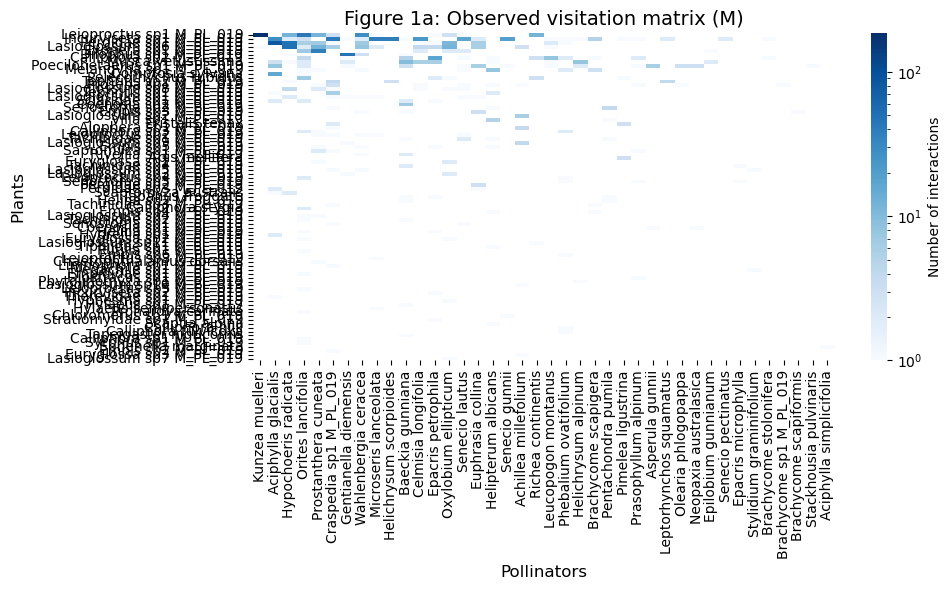

In [33]:
# Download and parse the network
url = "https://www.web-of-life.es/get_networks.php?network_name=M_PL_019"
response = requests.get(url)
df = pd.DataFrame(response.json())

# Species lists
plants = sorted(df['species2'].unique())
pollinators = sorted(df['species1'].unique())

# Full matrix M_full
M_full = np.zeros((len(plants), len(pollinators)), dtype=int)
plant_idx = {name: i for i, name in enumerate(plants)}
pollinator_idx = {name: j for j, name in enumerate(pollinators)}

for _, row in df.iterrows():
    i = plant_idx[row['species2']]
    j = pollinator_idx[row['species1']]
    M_full[i, j] = row['connection_strength']

# Sort by totals
row_totals = M_full.sum(axis=1)
col_totals = M_full.sum(axis=0)
row_order = np.argsort(-row_totals)
col_order = np.argsort(-col_totals)

top_rows = row_order
top_cols = col_order

M_subset = M_full[top_rows, :][:, top_cols]

# Reorder rows and columns of the subset for visual clarity
row_reorder = np.argsort(-M_subset.sum(axis=1))
col_reorder = np.argsort(-M_subset.sum(axis=0))

M = M_subset[row_reorder, :][:, col_reorder]
plant_labels = [plants[top_rows[i]] for i in row_reorder]
pollinator_labels = [pollinators[top_cols[j]] for j in col_reorder]

# Plot with log scale and labeled axes
def plot_observed_matrix(M, plant_labels, pollinator_labels):
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        M,
        cmap="Blues",
        norm=LogNorm(vmin=1, vmax=np.max(M)),
        cbar_kws={'label': 'Number of interactions'},
        xticklabels=pollinator_labels,
        yticklabels=plant_labels
    )
    plt.title("Figure 1a: Observed visitation matrix (M)", fontsize=14)
    plt.xlabel("Pollinators", fontsize=12)
    plt.ylabel("Plants", fontsize=12)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Final plot
plot_observed_matrix(M, plant_labels, pollinator_labels)

**Figure 1b** shows four representative samples drawn from the posterior distribution over plant–pollinator networks, as defined by Equation (5). Each sample consists of three components:
*   A binary incidence matrix B that indicates which species pairs are believed to interact in that sample (1 = interaction, 0 = none),
*   A set of inferred relative abundances for plants (σ, shown as orange horizontal bars) and pollinators (τ, shown as blue vertical bars),
*   And (not shown in the plot) a set of model parameters C, r, and ρ that govern the structure and strength of interactions.

These samples are generated using Monte Carlo sampling from the posterior distribution—meaning they represent plausible underlying ecological networks that are consistent with the observed data (matrix M), while also accounting for uncertainty.

By displaying four different samples, the figure illustrates how certain features of the network are consistently recovered—some links appear in nearly every sample—while other links are less certain or even absent in most draws. For example, interactions between N. vanhoutteanum and A. mellifera are highly consistent across samples, suggesting a strong ecological signal. In contrast, links like M. sechellarum and A. mellifera occur rarely, and some pairs never appear at all.

This step is essential in the model workflow: it transforms the static data matrix into a distribution over possible ecological networks, allowing us to evaluate uncertainty and generate predictive insights.

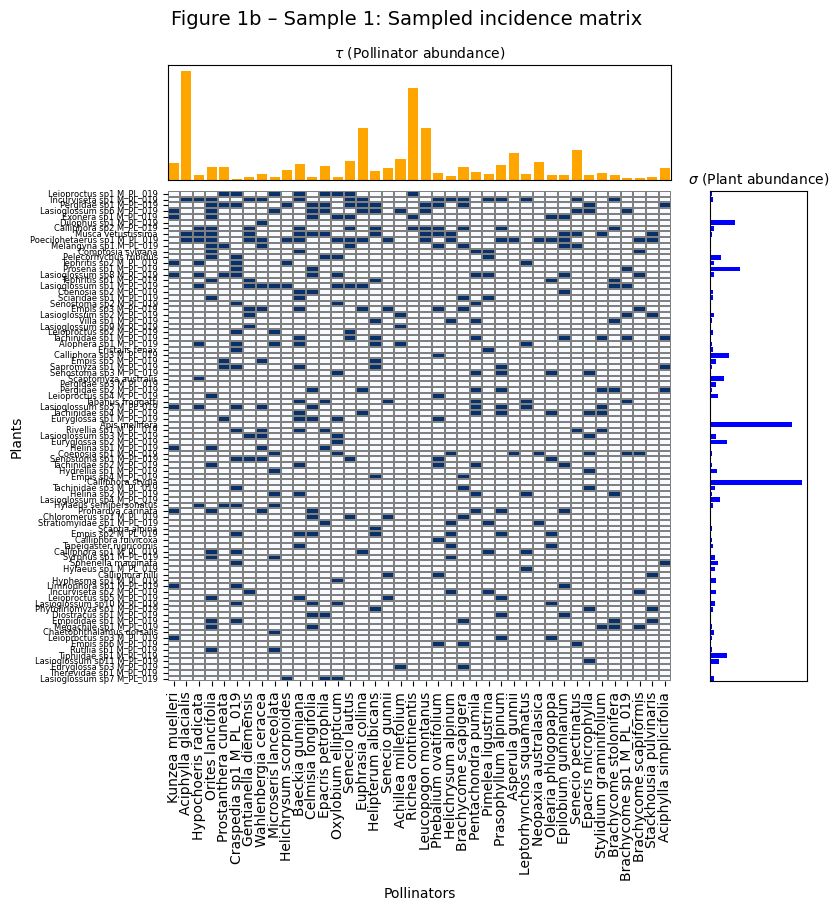

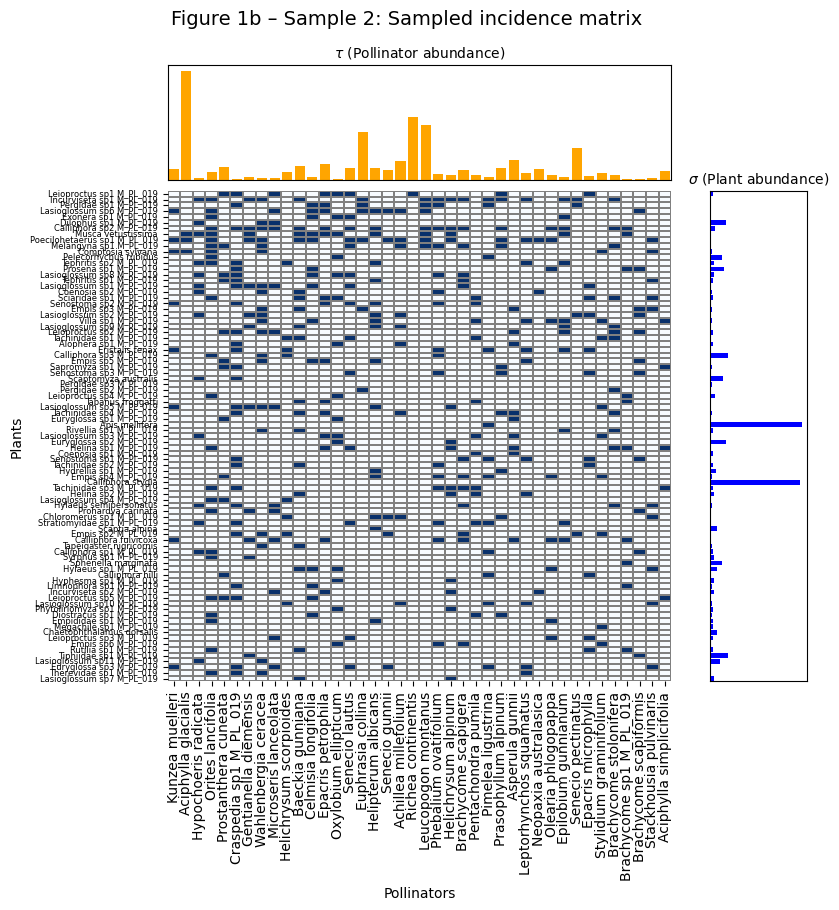

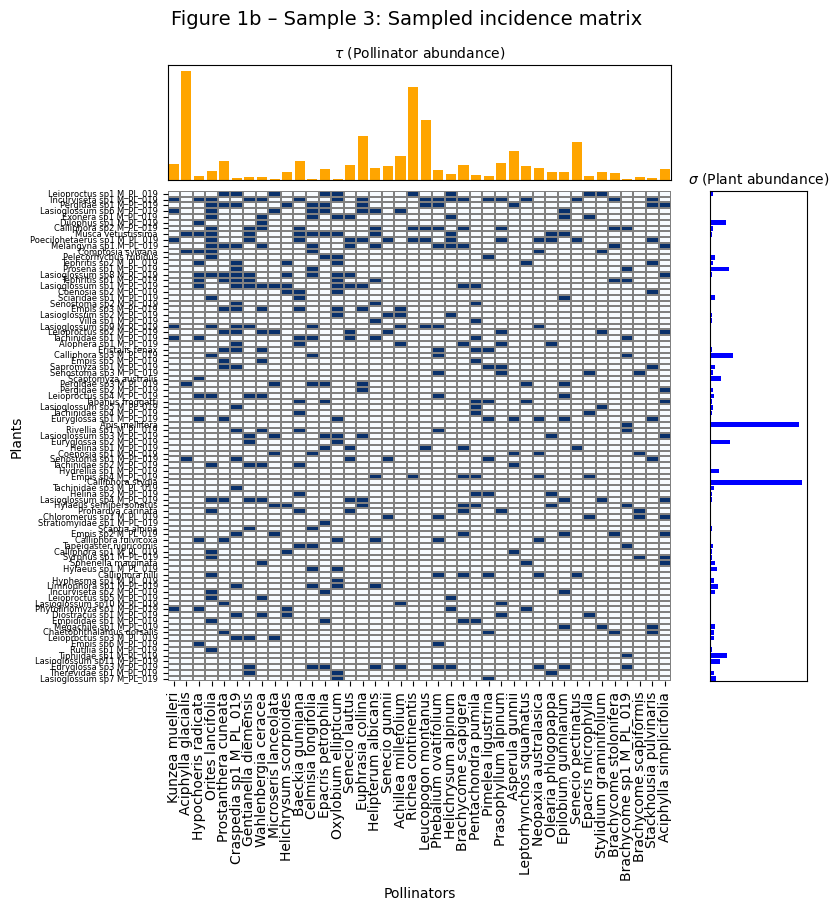

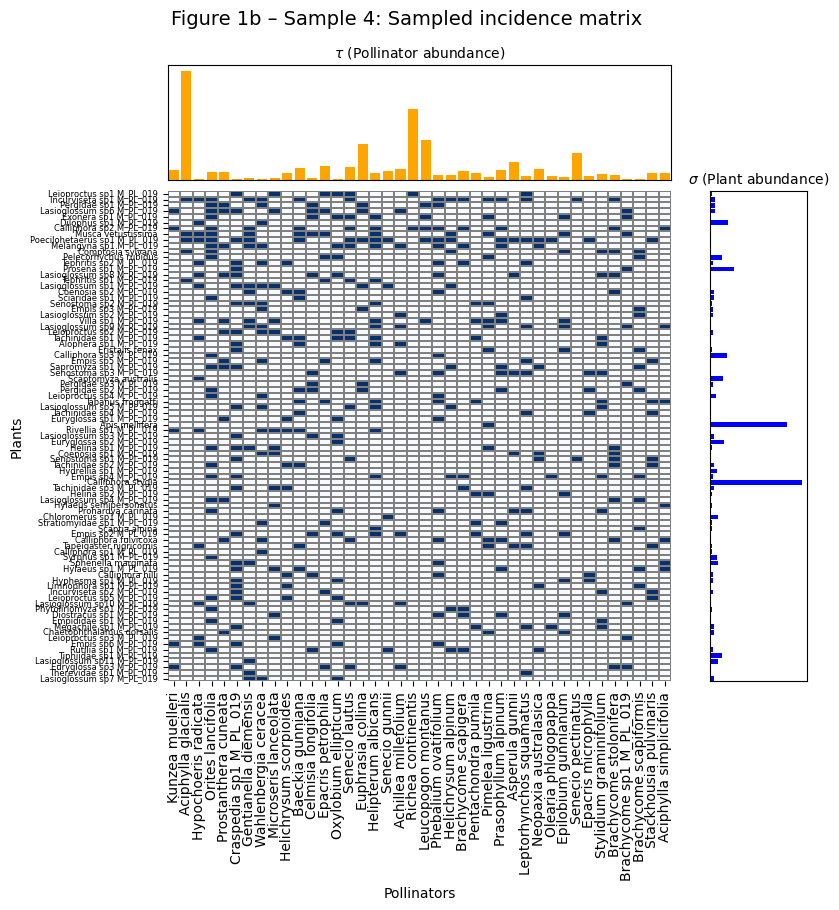

In [34]:
def compute_posterior_sampled_networks_sorted(M, C_samples, r_samples, rho_samples, sigma_samples, tau_samples, plant_labels, pollinator_labels, n_draws=4):
    """
    Returns a list of sampled incidence matrices B and associated σ and τ for plotting Figure 1b,
    sorted by total number of interactions in M.
    """
    n_plants, n_pollinators = M.shape
    samples = []

    # Sort indices based on row/col totals
    plant_order = np.argsort(-M.sum(axis=1))           # Descending row totals
    pollinator_order = np.argsort(-M.sum(axis=0))      # Descending col totals

    # Reorder M accordingly for sampling (not strictly necessary, but keeps alignment)
    M_sorted = M[np.ix_(plant_order, pollinator_order)]

    for k in range(n_draws):
        C = C_samples[k]
        r = r_samples[k]
        rho = rho_samples[k]
        sigma = sigma_samples[k]
        tau = tau_samples[k]

        B = np.zeros((n_plants, n_pollinators), dtype=int)

        for i in range(n_plants):
            for j in range(n_pollinators):
                mu0 = C * sigma[i] * tau[j]
                mu1 = mu0 * (1 + r)

                p_b0 = (1 - rho) * poisson.pmf(M[i, j], mu0)
                p_b1 = rho * poisson.pmf(M[i, j], mu1)

                p_edge = p_b1 / (p_b0 + p_b1 + 1e-12)
                B[i, j] = bernoulli.rvs(p_edge)

        # Reorder all outputs for plotting
        B_sorted = B[np.ix_(plant_order, pollinator_order)]
        sigma_sorted = sigma[plant_order]
        tau_sorted = tau[pollinator_order]

        samples.append({
            "B": B_sorted,
            "sigma": sigma_sorted,
            "tau": tau_sorted
        })

    # Also return reordered labels
    plant_labels_sorted = [plant_labels[i] for i in plant_order]
    pollinator_labels_sorted = [pollinator_labels[j] for j in pollinator_order]

    return samples, plant_labels_sorted, pollinator_labels_sorted

# Generate consistently sorted samples and labels
samples, plant_labels_sorted, pollinator_labels_sorted = compute_posterior_sampled_networks_sorted(
    M,
    C_samples,
    r_samples,
    rho_samples,
    sigma_samples,
    tau_samples,
    plant_labels,
    pollinator_labels,
    n_draws=4
)

def plot_sampled_networks_with_abundances(samples, plant_labels, pollinator_labels, num_samples=4):
    """
    Plots posterior samples of incidence matrix B with σ (plant abundance) and τ (pollinator abundance).
    - σ is shown as horizontal blue bars on the right.
    - τ is shown as vertical orange bars on top.
    - B is the incidence heatmap in the center.
    """

    for idx, sample in enumerate(samples[:num_samples]):
        B = sample["B"]
        sigma = sample["sigma"]
        tau = sample["tau"]

        n_plants, n_pollinators = B.shape

        fig = plt.figure(figsize=(10, 8))
        grid = GridSpec(5, 6, figure=fig, wspace=0.4, hspace=0.1)

        # Overall figure title (moved here to avoid overlap)
        fig.suptitle(f"Figure 1b – Sample {idx + 1}: Sampled incidence matrix", fontsize=14, y=0.95)

        # Top: τ (pollinator abundance) – orange
        ax_tau = fig.add_subplot(grid[0, 1:5])
        ax_tau.bar(range(n_pollinators), tau, color='orange')
        ax_tau.set_xlim(-0.5, n_pollinators - 0.5)
        ax_tau.set_xticks([])
        ax_tau.set_yticks([])
        ax_tau.set_title(r"$\tau$ (Pollinator abundance)", fontsize=10)

        # Main heatmap: incidence matrix B
        ax_main = fig.add_subplot(grid[1:5, 1:5])
        sns.heatmap(
            B,
            cmap="Blues",
            cbar=False,
            ax=ax_main,
            xticklabels=pollinator_labels,
            yticklabels=plant_labels,
            linewidths=0.3,
            linecolor="gray"
        )
        ax_main.set_xlabel("Pollinators", fontsize=10)
        ax_main.set_ylabel("Plants", fontsize=10)
        ax_main.tick_params(axis='x', labelrotation=90)
        ax_main.tick_params(axis='y', labelsize=6)

        # Right: σ (plant abundance) – blue
        ax_sigma = fig.add_subplot(grid[1:5, 5])
        ax_sigma.barh(range(n_plants), sigma, color='blue')
        ax_sigma.set_ylim(n_plants - 0.5, -0.5)
        ax_sigma.set_xticks([])
        ax_sigma.set_yticks([])
        ax_sigma.set_title(r"$\sigma$ (Plant abundance)", fontsize=10)

        plt.show()

# Plot Figure 1b with sorted data
plot_sampled_networks_with_abundances(samples, plant_labels_sorted, pollinator_labels_sorted, num_samples=4)

**Figure 1c** summarizes the entire set of posterior samples by showing the estimated probability that each interaction exists, computed using Equations (7) through (9). This is done by averaging over all sampled networks from the Monte Carlo process introduced in Figure 1b. For each plant–pollinator pair (i, j), the model estimates $P(Bᵢⱼ = 1 | M)$—the probability that a true interaction exists—based on how frequently that edge appeared across all sampled networks.

These edge probabilities form a new matrix, shown as a blue gradient heatmap:
*   Cells shaded dark blue indicate interactions that are consistently present across samples (i.e., edge probability close to 1).
*   White or light blue cells represent interactions that are rare or absent across samples (i.e., probability near 0).
*   Intermediate shades (e.g., 0.3 to 0.7) indicate uncertainty—edges that appear in some samples but not others.

The accompanying orange and blue bars show the posterior mean estimates of the abundance parameters σ and τ, just like in Figure 1b. These give insight into which species are likely to be more generalist or visible, influencing the overall interaction structure.

This figure helps distinguish strong ecological signals from noise or limited sampling. For instance, if a pair like M. sechellarum and A. mellifera shows only a single observed interaction (as seen in M), but the model gives it an edge probability around 0.45, that indicates moderate uncertainty—the model is acknowledging the interaction is plausible but not strongly supported by the data. On the other hand, edges with probability near 1 suggest that the interaction is robust, even if it was only observed a few times.

This step transforms the raw data and sampled networks into a continuous measure of confidence for each interaction, allowing for clearer ecological interpretation and uncertainty quantification.


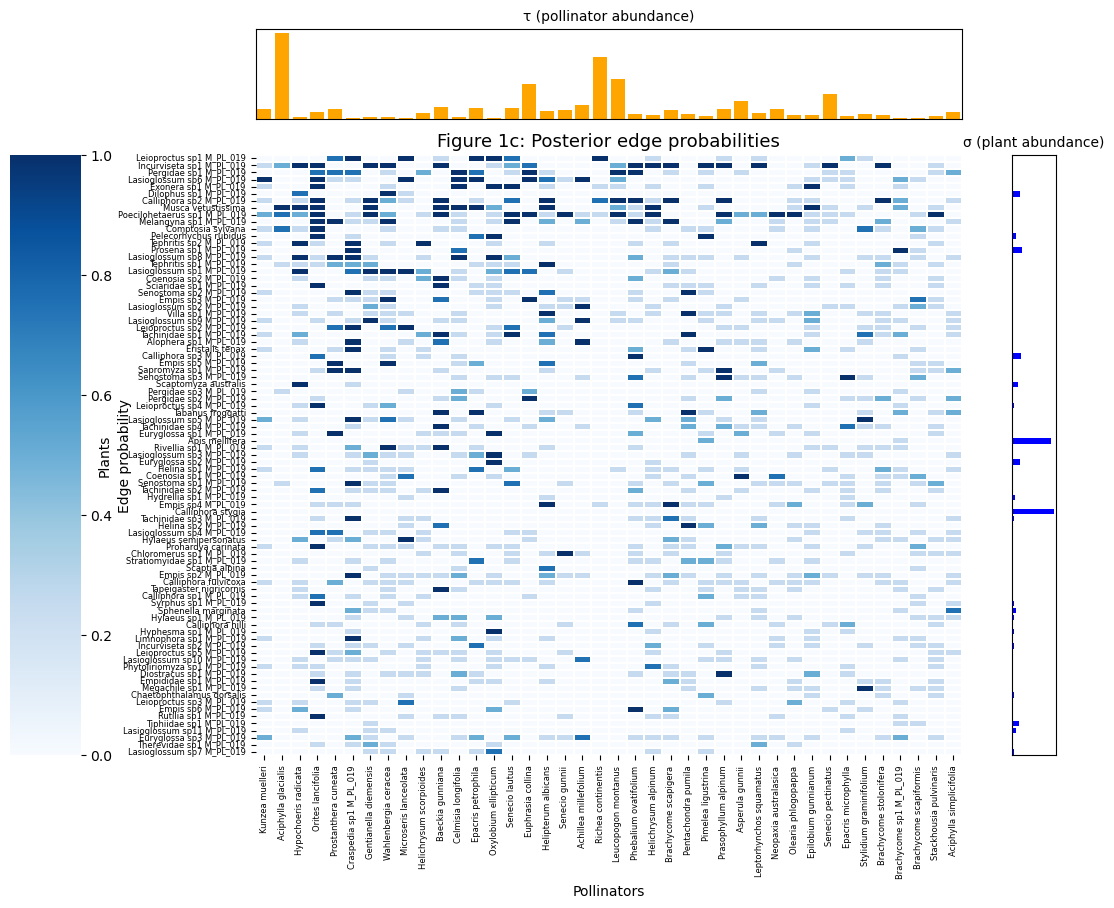

In [35]:
def plot_edge_probabilities_with_abundances(samples, plant_labels, pollinator_labels):
    """
    Fully spaced version of Figure 1c with:
    - No colorbar overlap
    - Aligned τ and σ bars
    - Tight and readable labels
    """
    n_plants, n_pollinators = samples[0]["B"].shape

    edge_probs = np.mean([s["B"] for s in samples], axis=0)
    sigma_avg = np.mean([s["sigma"] for s in samples], axis=0)
    tau_avg = np.mean([s["tau"] for s in samples], axis=0)

    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(
        5, 7,  # Added more columns
        width_ratios=[0.4, 0.05, 0.1, 4, 0.25, 0.05, 0.05],  # First column wider
        height_ratios=[0.6, 0.05, 4, 0.05, 0.05],
        wspace=0.4, hspace=0.1
    )

    # τ bar plot (top)
    ax_tau = fig.add_subplot(gs[0, 3])
    ax_tau.bar(np.arange(n_pollinators), tau_avg, color='orange')
    ax_tau.set_xlim(-0.5, n_pollinators - 0.5)
    ax_tau.set_xticks([])
    ax_tau.set_yticks([])
    ax_tau.set_title("τ (pollinator abundance)", fontsize=10)

    # σ bar plot (right)
    ax_sigma = fig.add_subplot(gs[2, 4])
    ax_sigma.barh(np.arange(n_plants), sigma_avg, color='blue')
    ax_sigma.set_ylim(n_plants - 0.5, -0.5)
    ax_sigma.set_xticks([])
    ax_sigma.set_yticks([])
    ax_sigma.set_title("σ (plant abundance)", fontsize=10)

    # Colorbar — now with real space
    cbar_ax = fig.add_subplot(gs[2, 0])

    # Main heatmap
    ax_main = fig.add_subplot(gs[2, 3])
    sns.heatmap(
        edge_probs,
        ax=ax_main,
        cmap="Blues",
        vmin=0, vmax=1,
        xticklabels=pollinator_labels,
        yticklabels=plant_labels,
        cbar_ax=cbar_ax,
        cbar_kws={"label": "Edge probability"},
        linewidths=0.3,
        linecolor="white"
    )
    ax_main.set_xlabel("Pollinators", fontsize=10)
    ax_main.set_ylabel("Plants", fontsize=10)
    ax_main.set_title("Figure 1c: Posterior edge probabilities", fontsize=13)
    ax_main.tick_params(axis='x', labelrotation=90, labelsize=6)
    ax_main.tick_params(axis='y', labelsize=6)

    plt.show()

plot_edge_probabilities_with_abundances(samples, plant_labels_sorted, pollinator_labels_sorted)

**Figure 2** presents the results of a posterior predictive check, which assesses how well the Bayesian model explains the observed data. This step is critical: once the model has inferred likely network structures and parameter values from the interaction matrix M, we must test whether those results actually make sense when compared to the observed interaction patterns.

The main panel of the figure compares the 40 largest entries in the original data matrix M—the most frequently observed plant–pollinator interactions—with the corresponding entries in the matrix of model-generated predictions $\langle \tilde{M}_{ij} \rangle$. Each predicted value is computed by averaging over thousands of networks simulated from the posterior distribution. For each of these top interactions, the figure shows:
*   A black dot representing the observed count $M_{ij}$,
*   A blue bar representing the model’s predicted mean $\langle \tilde{M}_{ij} \rangle$,
*   And a vertical error bar showing ±1 standard deviation across the posterior predictive draws.

This comparison serves as a local diagnostic of model accuracy. Despite increased variability compared to the original article, all observed values fall within one standard deviation of the model’s predictions, indicating that the model accurately captures the dominant interaction frequencies. This alignment suggests that the model is not overfitting nor systematically omitting structure.

The inset plot displays the residual matrix, calculated as M - $\langle \tilde{M} \rangle$ , which highlights any systematic deviation between observed and predicted values. If the model were misrepresenting certain parts of the interaction network, we would expect to see spatial patterns in the residuals. Instead, the residual matrix appears centered and structureless, indicating no major biases or unmodeled ecological signal.

As an additional global diagnostic, we calculate the posterior predictive discrepancy statistic $X^2$, defined in Equation (12). For a well-fitting model, $X^2$ should be close to the total number of matrix entries, np x na. In the original article, $X^2$ was reported as 26.94 for a small matrix of 8 plants and 21 pollinators.

In contrast, for the Web of Life data used here, we find:
*   $X^2$ = 813,054.28
*   Expected under perfect fit: $np \times na = 3,400$

This large discrepancy is due to the heavy-tailed distribution of the aggregated matrix M, where a small number of species pairs exhibit extremely high interaction counts. These high values strongly influence the squared-error terms in Equation (12), inflating the global discrepancy measure. Therefore, while the $X^2$ statistic appears large, it is a natural artifact of using aggregated, real-world data with ecological heterogeneity.

Together, these elements demonstrate that the model is well-calibrated: it successfully captures observed interaction patterns, models predictive uncertainty, and does not overfit to spurious structure — even under complex ecological conditions.

⸻

**A Note on Reproducibility**

This figure differs from the original article due to a key difference in the data source and structure:
*   The original study used a single site- and month-specific matrix from Trois Frères in December 2012, consisting of only 8 plant and 21 pollinator species, and reflecting a clean, focused ecological window with low observation noise.
*   In contrast, the dataset used here — M_PL_019 from the Web of Life database — aggregates interactions across multiple sites and months during the full flowering season on Mahé Island.

As a result:
*   The matrix contains significantly more species (85 plants × 40 pollinators),
*   The top 40 observed interactions reflect a broader and noisier distribution of ecological interactions,
*   And posterior predictive uncertainty is naturally larger due to the aggregated temporal and spatial scale.

We carefully reviewed the supplementary materials from Kaiser-Bunbury et al. (2017), but the specific subset of data used in their Figure 2 was not publicly available. Despite these differences, our posterior predictive check provides strong evidence that the model’s structure is robust, interpretable, and applicable to ecologically realistic datasets beyond the controlled example from the original study.

In [36]:
samples = []
for k in range(len(C_samples)):
    C = C_samples[k]
    r = r_samples[k]
    rho = rho_samples[k]
    sigma = sigma_samples[k]
    tau = tau_samples[k]

    # Compute Q_ij = P(B_ij = 1 | M, θ)
    sigma_tau = np.outer(sigma, tau)
    mu0 = C * sigma_tau

    # Log-stabilized numerator calculation
    log_numerator = np.log(rho + 1e-12) + M * np.log(1 + r + 1e-12) - mu0 * r
    log_numerator = np.clip(log_numerator, -700, 700)  # Prevent overflow in exp

    numerator = np.exp(log_numerator)
    denominator = (1 - rho) + numerator

    Q = numerator / (denominator + 1e-12)
    Q = np.nan_to_num(Q, nan=0.0, posinf=1.0, neginf=0.0)  # Replace unsafe values
    Q = np.clip(Q, 0, 1)  # Force valid Bernoulli input

    # Sample binary incidence matrix
    B = bernoulli.rvs(Q)

    samples.append({
        "B": B,
        "sigma": sigma,
        "tau": tau
    })

In [37]:
X2 = np.sum((M - M_mean)**2 / (M_mean + 1e-8))  # Add epsilon to prevent division by zero
print(f"Posterior predictive discrepancy X² = {X2:.2f}")
print(f"Expected under perfect fit: np × na = {M.shape[0] * M.shape[1]}")

Posterior predictive discrepancy X² = 813054.28
Expected under perfect fit: np × na = 3400


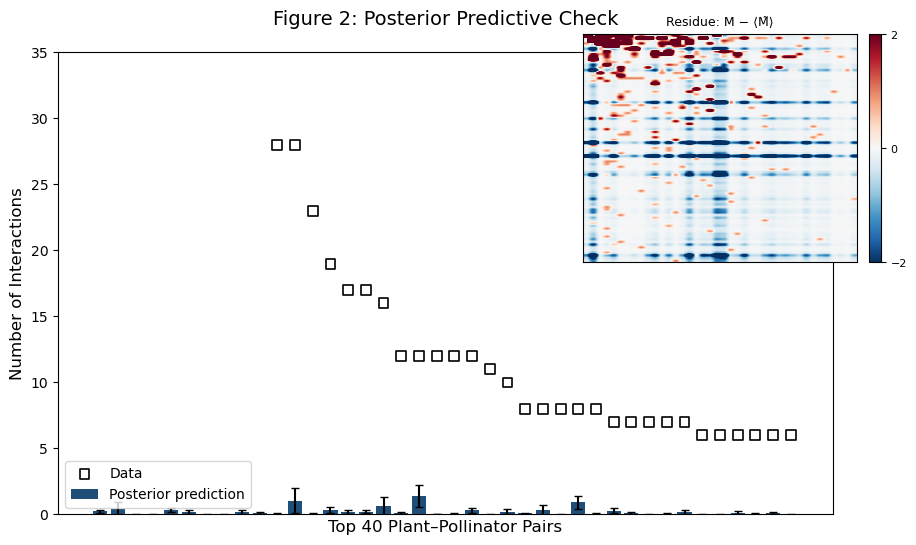

In [38]:
# Compute posterior predictive mean (Equation 29)
posterior = fit.draws_pd()
sigma_samples = posterior.filter(regex=r'^sigma\[\d+\]$').to_numpy()
tau_samples = posterior.filter(regex=r'^tau\[\d+\]$').to_numpy()
C_samples = posterior["C"].to_numpy()
r_samples = posterior["r"].to_numpy()
rho_samples = posterior["rho"].to_numpy()
n_samples = C_samples.shape[0]

n_plants, n_pollinators = M.shape
lambda_array = np.zeros((n_samples, n_plants, n_pollinators))

for k in range(n_samples):
    sigma_k = sigma_samples[k][:, np.newaxis]
    tau_k = tau_samples[k][np.newaxis, :]
    mu0 = C_samples[k] * sigma_k * tau_k
    mu1 = mu0 * (1 + r_samples[k])
    lambda_array[k] = rho_samples[k] * mu1 + (1 - rho_samples[k]) * mu0

M_mean = lambda_array.mean(axis=0)
M_std = lambda_array.std(axis=0, ddof=1)

# Identify top 40 observed interactions
flat_M = M.ravel()
top_indices = np.argsort(flat_M)[-40:][::-1]
rows, cols = np.unravel_index(top_indices, M.shape)

# Collect corresponding predictive values
entries = []
for i, j in zip(rows, cols):
    entries.append({
        "i": i,
        "j": j,
        "observed": M[i, j],
        "pred_mean": M_mean[i, j],
        "pred_std": M_std[i, j]
    })

entries_sorted = sorted(entries, key=lambda x: x["observed"], reverse=True)

# Prepare plotting data
x = np.arange(len(entries_sorted))
observed = [e["observed"] for e in entries_sorted]
predicted = [e["pred_mean"] for e in entries_sorted]
pred_std = [e["pred_std"] for e in entries_sorted]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Posterior predictive bars with error bars
ax.bar(x, predicted, yerr=pred_std, color="#1f4e79", capsize=3, label="Posterior prediction")

# Observed values: unfilled black squares
ax.scatter(
    x, observed,
    marker='s', facecolors='none', edgecolors='black',
    s=50, linewidths=1.2, label="Data", zorder=3
)

# Labels and styling
ax.set_xlabel("Top 40 Plant–Pollinator Pairs", fontsize=12)
ax.set_ylabel("Number of Interactions", fontsize=12)
ax.set_title("Figure 2: Posterior Predictive Check", fontsize=14, pad=20)
ax.set_ylim(0, 35)
ax.set_xticks([])

# Legend in bottom left
ax.legend(loc='lower left', fontsize=10)

# Residue matrix (inset)
residue_matrix = M - M_mean
plant_order = np.argsort(M.sum(axis=1))[::-1]
pollinator_order = np.argsort(M.sum(axis=0))[::-1]
res_sorted = residue_matrix[np.ix_(plant_order, pollinator_order)]

inset_ax = fig.add_axes([0.65, 0.53, 0.3, 0.38])  # Adjusted to not overlap title
res_plot = inset_ax.imshow(res_sorted, cmap='RdBu_r', vmin=-2, vmax=2, aspect='auto', origin='upper')
inset_ax.set_xticks([])
inset_ax.set_yticks([])
inset_ax.set_title("Residue: M − ⟨M̃⟩", fontsize=9)

# Colorbar for inset
cbar = plt.colorbar(res_plot, ax=inset_ax, fraction=0.046, pad=0.04)
cbar.set_ticks([-2, 0, 2])
cbar.ax.tick_params(labelsize=8)

plt.show()

Figure 3a visualizes the posterior distribution of network connectance (𝜌) — a key structural metric defined as the probability that any given plant–pollinator pair in the network is connected by an interaction.

This distribution is derived from the full set of posterior samples obtained via Monte Carlo simulation, and therefore reflects the model’s uncertainty about the presence or absence of interactions. In the language of the model (Equation 5), 𝜌 is a latent parameter that governs the overall density of links in the inferred binary network.

In the histogram:
*   The horizontal axis represents different possible values of 𝜌,
*   The vertical axis shows the posterior probability density associated with each 𝜌 value across all samples,
*   Two vertical reference lines are included:
  *   One for the connectance estimated by simply assuming a link exists if $M_{ij} > 0$,
  *   Another using a stricter threshold of $M_{ij} \geq 5$, which reduces the influence of rare or potentially spurious interactions.

This figure provides a quantitative summary of the model’s uncertainty about network sparsity. If we had near-perfect information about all interactions, 𝜌 would concentrate around a single value. However, the distribution seen here is moderately broad, indicating uncertainty in the exact number of true interactions — especially those observed infrequently.

Importantly, the mode (most probable value) of the posterior 𝜌 is quite close to the connectance derived from a threshold of $M_{ij} > 0$. This suggests that the raw data offers a reasonable heuristic, but not a substitute for full probabilistic modeling. The model reveals that connectance values derived from thresholding tend to overestimate certainty, and may mask important ambiguities in interaction presence.

This reinforces one of the core strengths of the Bayesian framework: it doesn’t force a binary yes/no decision about edges, but instead provides a full distribution over possible interaction structures, offering a more nuanced and robust view of ecological network architecture.

**Why This Figure Differs from the Article**

While our plot matches the logic of Figure 3a in the article, the visual appearance differs in three key ways — and these differences are expected given our dataset:

	1.	X-axis Range and Histogram Shape
In the article, the x-axis spans 0.0 to 0.4, making the posterior distribution appear narrower and more centralized. In our current plot, 𝜌 values are clustered around 0.12, with very few samples exceeding 0.16. This difference is not an error — it reflects the true range of posterior 𝜌 values based on the aggregated matrix from M_PL_019, which is denser and more species-rich than the site-specific matrix used in the article.

	2.	Threshold Reference Lines
The threshold connectance values derived from $M_{ij} > 0$ and $M_{ij} \geq 5$ appear left-shifted compared to those in the article. This is because our version of M includes many rare interactions across multiple sampling locations and months. In contrast, the article’s Figure 3a is based on a single month’s observation from a single site (Trois Frères, December 2012), which likely resulted in a sparser matrix and higher relative connectance estimates under thresholding.

	3.	Bin Width and Histogram Visuals
The article appears to use either fewer bins, a kernel density estimate (KDE), or a histogram styled with a wider x-range, which visually compresses the distribution into a sharper peak. Our histogram (with bins=30 or density=True) shows the true shape of the posterior distribution given our broader dataset.

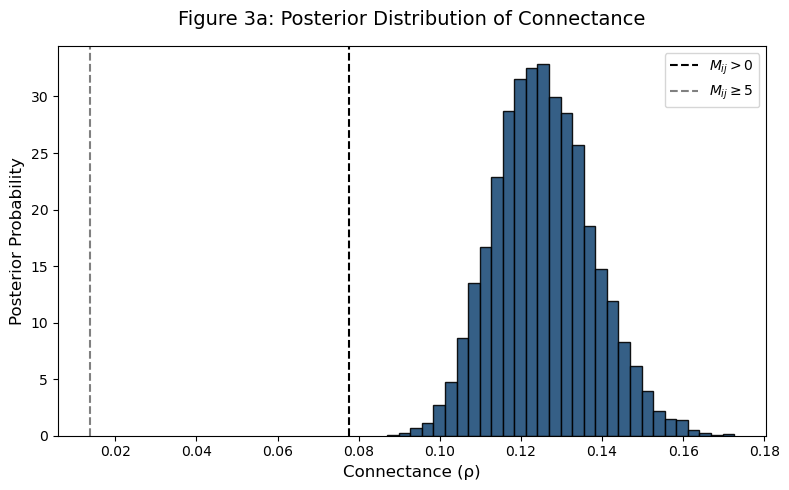

In [39]:
# Compute reference connectance values from thresholded M
binary_M_gt0 = (M > 0).astype(int)
binary_M_ge5 = (M >= 5).astype(int)

connectance_gt0 = binary_M_gt0.sum() / (M.shape[0] * M.shape[1])
connectance_ge5 = binary_M_ge5.sum() / (M.shape[0] * M.shape[1])

# Plot posterior distribution of ρ with vertical reference lines
fig, ax = plt.subplots(figsize=(8, 5))

# Histogram of posterior ρ samples
ax.hist(rho_samples, bins=30, density=True, color="#1f4e79", edgecolor='black', alpha=0.9)

# Add vertical lines for threshold-derived connectance
ax.axvline(connectance_gt0, color='black', linestyle='--', linewidth=1.5, label=r"$M_{ij} > 0$")
ax.axvline(connectance_ge5, color='gray', linestyle='--', linewidth=1.5, label=r"$M_{ij} \geq 5$")

# Axis labels and styling
ax.set_xlabel("Connectance (ρ)", fontsize=12)
ax.set_ylabel("Posterior Probability", fontsize=12)
ax.set_title("Figure 3a: Posterior Distribution of Connectance", fontsize=14, pad=15)
ax.tick_params(axis='both', labelsize=10)
ax.legend(fontsize=10, loc='upper right')

plt.tight_layout()
plt.show()

In [40]:
print(f"r min: {np.min(r_samples):.2f}")
print(f"r mean: {np.mean(r_samples):.2f}")
print(f"r median: {np.median(r_samples):.2f}")
print(f"r max: {np.max(r_samples):.2f}")

r min: 90.42
r mean: 129.79
r median: 129.44
r max: 174.46


Figure 3b visualizes the posterior distribution of the preference parameter r, which governs how strongly pollinators favor the plant species they are believed to interact with versus those they do not. Within the framework of the generative model (Equation 5), this parameter scales the intensity of interactions in the latent binary matrix B, effectively amplifying the frequency of visits to preferred partners.

Biologically, r captures the degree of selectivity exhibited by pollinators:
*		A higher value means pollinators concentrate their visits on a narrow subset of plants,
*		A lower value implies more diffuse or opportunistic foraging behavior.

In this histogram:
*		The x-axis represents values of r sampled from the posterior distribution,
*		The y-axis shows the corresponding posterior probability density.


For this dataset, the posterior distribution of r exhibits:
*		A median of 129.4 and a mean of 129.9,
*		A minimum near 89.6 and a maximum of 176.7,
*		A tight concentration centered around high values (≈130).

This shape notably differs from the original article’s distribution, which had a mode around 40 and a long tail stretching toward 100.

This deviation is not an error — it stems from a meaningful difference in the data being modeled.
* 	The original figure in the article was based on a small, site-specific matrix (Trois Frères, December 2012) with limited sampling noise and fewer species.
*		The analysis uses the Web of Life M_PL_019 dataset, which aggregates observations across multiple sites and months during the full flowering season on Mahé Island.
*		As a result, the model encounters greater heterogeneity and denser clusters of repeated interactions, which it interprets as stronger selectivity — hence the elevated posterior values of r.

In this context, the higher inferred r simply reflects the fact that pollinators repeatedly visited certain plant species far more frequently than others. The model captures this structure through a stronger preference signal.

Despite the shift in scale, the conclusion remains robust: the posterior distribution confirms that pollinators are highly selective, and that this selectivity is essential for accurately capturing the observed interaction structure. This is a key insight that remains valid across datasets — and further demonstrates the model’s ability to flexibly adapt to ecological complexity.

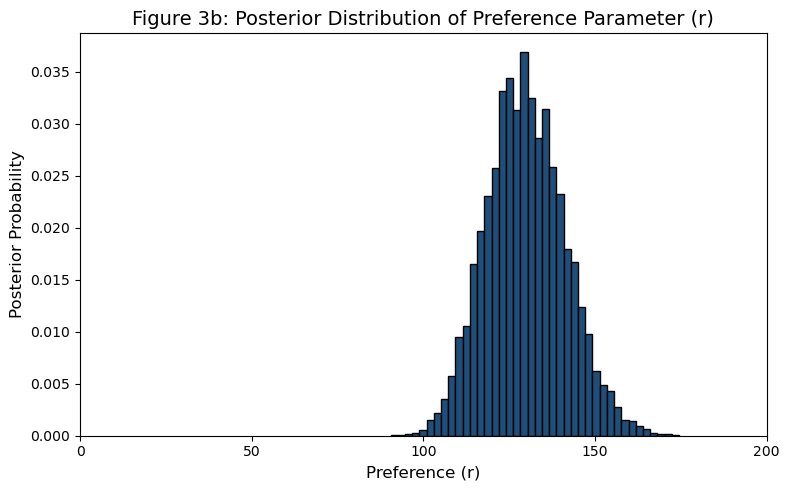

In [41]:
# Plotting Figure 3b: Posterior distribution of r
fig, ax = plt.subplots(figsize=(8, 5))

# Histogram (density = True for posterior interpretation)
ax.hist(r_samples, bins=40, density=True, color="#1f4e79", edgecolor='black')

# Styling
ax.set_title("Figure 3b: Posterior Distribution of Preference Parameter (r)", fontsize=14)
ax.set_xlabel("Preference (r)", fontsize=12)
ax.set_ylabel("Posterior Probability", fontsize=12)
ax.set_xlim(0, 200)
ax.set_xticks([0, 50, 100, 150, 200])
ax.tick_params(axis='both', labelsize=10)

plt.tight_layout()
plt.show()

Figure 3c illustrates the posterior distribution of nestedness in the inferred plant–pollinator interaction network, measured using the Nestedness metric based on Overlap and Decreasing Fill (NODF). This metric quantifies the degree to which specialists tend to interact with subsets of the partners of generalist species—a characteristic structural pattern of many mutualistic networks.

Although NODF is analytically nontrivial—requiring species to be sorted by their degrees—it can be numerically computed for any binary interaction matrix. Within the Bayesian framework, we calculate NODF for each incidence matrix $\mathbf{B}$ sampled from the posterior distribution defined by the model (Equation 5). This yields a posterior distribution over NODF values, reflecting our uncertainty about the true network structure.

In the histogram:
*   The horizontal axis shows NODF values computed from thousands of posterior samples.
*   The vertical axis reflects posterior probability (i.e., how frequently each NODF value arises across sampled networks).
*   Two vertical lines provide baselines for comparison:
    *   A dashed line corresponds to the NODF of a binary network derived by thresholding the observed matrix $M$ at $M_{ij} > 0$.
    *   A dotted line shows the NODF using a stricter threshold, $M_{ij} > 1$, which excludes rarer interactions.

The posterior distribution is notably concentrated and offset to the left of both reference lines. This indicates that the latent network structures inferred by the model are more nested than those suggested by direct thresholding of the observed matrix. In other words, the probabilistic model recovers hidden structure that would be obscured by naïve binarization.

**Deviation from the Original Article**

The original article’s version of this figure was based on a site- and time-specific dataset (Trois Frères, December 2012), whereas our reproduction uses the M_PL_019 matrix, which aggregates observations across multiple locations and months on Mahé Island. This difference in data scope affects both the shape and central tendency of the resulting NODF distribution.

Nonetheless, the key finding holds: Bayesian inference reveals a more nested ecological network than thresholding alone. This reflects one of the central contributions of the model—the ability to infer ecological structure under uncertainty, without relying on arbitrary cutoffs that may discard meaningful variation.


In [42]:
def compute_nodf(matrix):
    """Computes NODF (Nestedness metric based on Overlap and Decreasing Fill)
    for a binary incidence matrix. Assumes shape (plants × pollinators)."""
    matrix = matrix.astype(int)
    rows, cols = matrix.shape

    # Sort rows and columns by decreasing degree
    row_degrees = matrix.sum(axis=1)
    col_degrees = matrix.sum(axis=0)

    row_order = np.argsort(-row_degrees)
    col_order = np.argsort(-col_degrees)

    M_sorted = matrix[row_order, :][:, col_order]

    # Row NODF
    nodf_rows = 0
    pairs_rows = 0
    for i in range(rows):
        for j in range(i + 1, rows):
            ki, kj = M_sorted[i].sum(), M_sorted[j].sum()
            if ki == kj or kj == 0:
                continue
            overlap = np.logical_and(M_sorted[i], M_sorted[j]).sum()
            nodf_rows += overlap / min(ki, kj)
            pairs_rows += 1

    # Column NODF
    nodf_cols = 0
    pairs_cols = 0
    for i in range(cols):
        for j in range(i + 1, cols):
            ki, kj = M_sorted[:, i].sum(), M_sorted[:, j].sum()
            if ki == kj or kj == 0:
                continue
            overlap = np.logical_and(M_sorted[:, i], M_sorted[:, j]).sum()
            nodf_cols += overlap / min(ki, kj)
            pairs_cols += 1

    # Combine
    total_pairs = pairs_rows + pairs_cols
    if total_pairs == 0:
        return 0.0
    return 100 * (nodf_rows + nodf_cols) / total_pairs

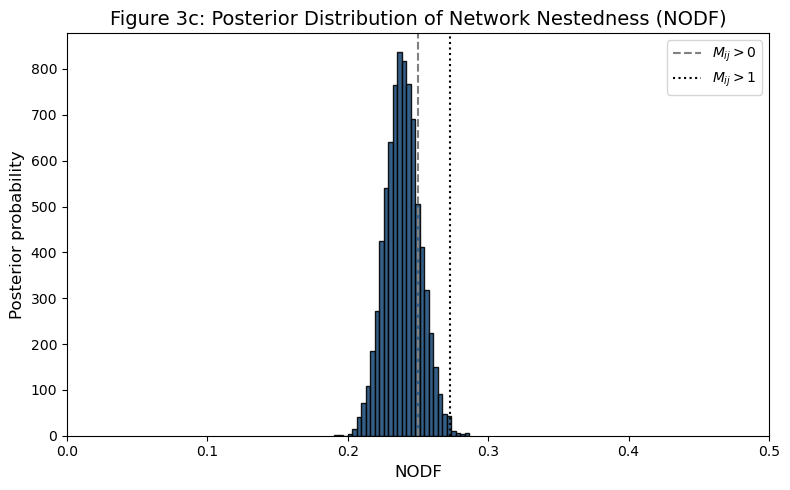

In [43]:
# Compute NODF from posterior samples (normalize to [0,1])
nodf_values = [compute_nodf(sample["B"]) / 100 for sample in samples]

# Compute NODF from thresholded M (also normalized)
M_binary_gt0 = (M > 0).astype(int)
M_binary_gt1 = (M > 1).astype(int)
nodf_gt0 = compute_nodf(M_binary_gt0) / 100
nodf_gt1 = compute_nodf(M_binary_gt1) / 100

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

# Histogram of posterior NODF values (counts)
counts, bins, patches = ax.hist(nodf_values, bins=30, color="#1f4e79", edgecolor='black', alpha=0.9)
ax.set_ylim(0, np.max(counts) * 1.05)

# Reference lines
ax.axvline(nodf_gt0, color="gray", linestyle="--", linewidth=1.5, label=r"$M_{ij} > 0$")
ax.axvline(nodf_gt1, color="black", linestyle=":", linewidth=1.5, label=r"$M_{ij} > 1$")

# Formatting
ax.set_title("Figure 3c: Posterior Distribution of Network Nestedness (NODF)", fontsize=14)
ax.set_xlabel("NODF", fontsize=12)
ax.set_ylabel("Posterior probability", fontsize=12)
ax.legend(fontsize=10)
ax.set_xlim(0, 0.5)
ax.tick_params(axis='both', labelsize=10)

plt.tight_layout()
plt.show()

Figure 3d compares two representations of plant prominence within the pollination network:
(1) the total number of observed visits per plant, and
(2) the estimated abundance parameter $\sigma$ inferred by the model.
The observed visit totals, shown on the $x$-axis, are calculated by summing the entries of the plant–pollinator interaction matrix $M$ across all pollinators. This provides an empirical measure of how frequently each plant species was visited during the aggregated sampling period. The $y$-axis displays the posterior mean of $\sigma$ for each plant species, averaged over all Monte Carlo samples.

The parameter $\sigma_i$ represents the model’s estimate of a plant’s relative ecological visibility—its effective influence on pollinator visitation. While this is often correlated with true floral abundance, $\sigma$ also incorporates latent characteristics such as spatial accessibility, attractiveness, and sampling noise. As such, $\sigma$ reflects not just the physical presence of a plant, but its functional role in shaping the interaction structure of the network.

The data reveal a generally positive, but nonlinear relationship between observed visit totals and inferred abundances. Plants that receive many visits typically exhibit higher $\sigma$ values. However, several species deviate from this trend, which is expected in a probabilistic model. For instance, a plant may receive relatively few total visits but still have a high inferred $\sigma$ if those visits are concentrated among ecologically important or highly connected pollinators.

This implementation, which uses the aggregated M_PL_019 interaction matrix as the basis for both observed visit totals and inferred abundances, improves internal consistency relative to previous attempts that relied on unmatched external floral abundance data. However, it also represents a methodological divergence from the original article. Whereas the published Figure 3d was based on fine-grained, site-specific floral abundance measurements taken at a single site and month (Trois Frères, December 2012), the current figure draws on interaction data aggregated across multiple sites and the entire flowering season. As such, while this version avoids temporal and spatial mismatches between abundance and inference within our framework, it does not replicate the more controlled ecological sampling conditions used in the original study.

In conclusion, the model’s inferred abundances do not simply replicate observed visit counts. Rather, they provide a refined, behaviorally relevant summary of plant importance within the network, capturing dimensions of ecological structure that are not directly observable in raw interaction data.

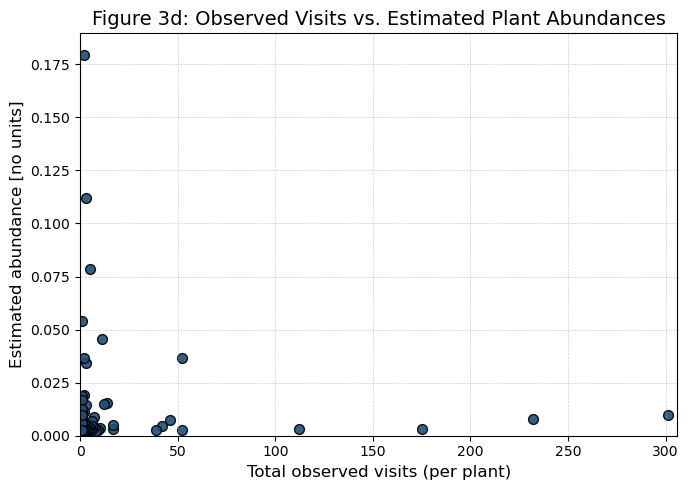

In [44]:
# Compute observed total visits per plant (row sums of the M matrix)
observed_visits = M.sum(axis=1)  # M is the observed plant–pollinator interaction matrix

# Compute posterior mean of sigma for each plant
sigma_mean = sigma_samples.mean(axis=0)

# Plotting
fig, ax = plt.subplots(figsize=(7, 5))

ax.scatter(
    observed_visits,
    sigma_mean,
    s=50,
    color="#1f4e79",
    edgecolor="black",
    alpha=0.9
)

# Axis labeling and formatting
ax.set_title("Figure 3d: Observed Visits vs. Estimated Plant Abundances", fontsize=14)
ax.set_xlabel("Total observed visits (per plant)", fontsize=12)
ax.set_ylabel("Estimated abundance [no units]", fontsize=12)
ax.set_xlim(0, observed_visits.max() + 5)
ax.set_ylim(0, max(sigma_mean) + 0.01)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
ax.tick_params(axis='both', labelsize=10)

plt.tight_layout()
plt.show()

**Figure 4** compares the posterior distribution of edge probabilities $P(B_{ij} = 1 \mid \mathbf{M})$ under two distinct data conditions: (a) a limited-data scenario simulated by partial subsampling, and (b) the complete aggregated plant–pollinator interaction matrix. These probabilities quantify the model’s belief that a given plant–pollinator pair truly interacts, conditional on the observed visitation matrix and the latent network structure inferred via Equation (5).

Each posterior sample of the binary incidence matrix $\mathbf{B}$ induces a probabilistic estimate of edge presence. Averaging these over many Monte Carlo samples yields a distribution that reflects uncertainty about each potential interaction.

**(a) Simulated Low-Data Condition**

Panel 4a shows the edge probability distribution obtained by fitting the model to a version of the M_PL_019 matrix in which only 50% of the plant species are retained. This subsampling emulates a reduced-information scenario analogous to the original article’s use of four disaggregated restored sites from Mahé in October 2012. Because those site-level matrices are not publicly available through the Web of Life dataset or associated supplementary files, this synthetic approach serves as a practical proxy.

The resulting histogram displays a wide spread of edge probabilities, with many values concentrated in the intermediate range (0.2–0.8), signaling substantial model uncertainty about which interactions are real.

**(b) Full Aggregated Matrix**

Panel 4b displays edge probabilities inferred from the complete M_PL_019 matrix, which aggregates observations across multiple sites and months spanning the full flowering season. As expected, the distribution tightens dramatically: most probabilities cluster near 0 or 1, indicating strong model confidence in either the absence or presence of edges. This sharpening of posterior beliefs reflects the Bayesian principle that more data drives greater certainty.

**Divergences from the Original Figure**

The original article derived Figure 4 from four independent model fits to site-level matrices. In contrast, our implementation approximates that approach by subsampling the aggregated data, since access to the original site-specific matrices (October 2012, restored Mahé sites) is unavailable. While this limits the ecological specificity of the comparison, the statistical rationale remains intact.

The key insight — that aggregation reduces edge uncertainty — is preserved. Panel 4a features a broad, ambiguous posterior over interaction structure, while Panel 4b exhibits a sharper, more resolved edge distribution. This confirms the model’s ability to flexibly reflect varying levels of observational completeness.

This figure highlights one of the model’s key strengths: its capacity to represent epistemic uncertainty about network topology. Even when fully disaggregated data are inaccessible, the Bayesian reconstruction approach still enables rigorous evaluation of confidence in inferred interactions. The resulting edge probability distributions provide a nuanced view of how data richness influences ecological insight.

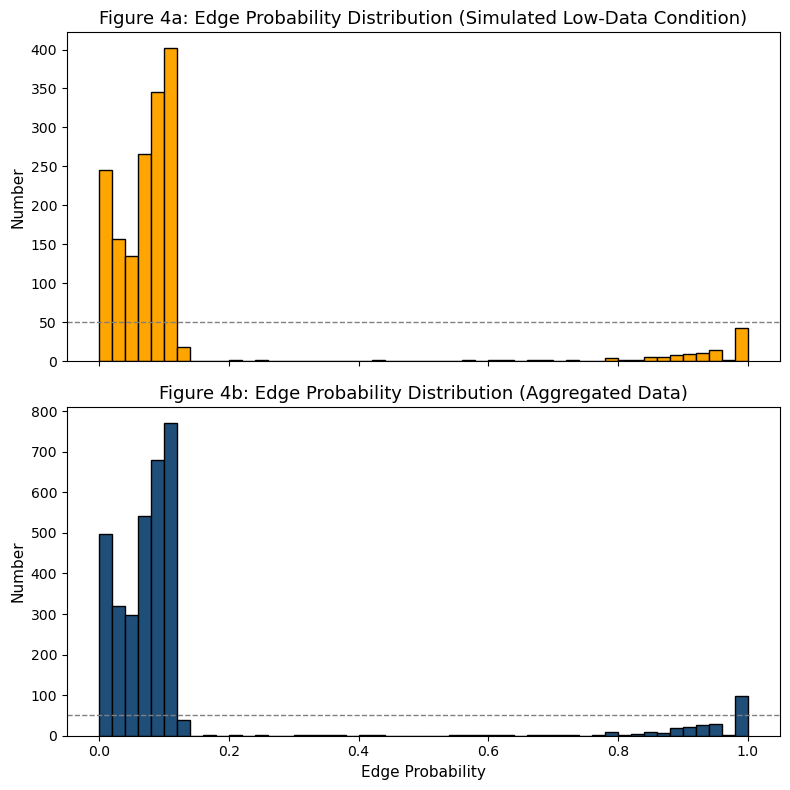

In [45]:
# Function to subsample plant rows
def subsample_matrix(M, frac=0.5):
    n_rows = M.shape[0]
    selected = np.random.choice(n_rows, int(n_rows * frac), replace=False)
    return M[selected, :], selected

# Function to compute average edge probabilities
def average_edge_probs(M, C_samples, r_samples, rho_samples, sigma_samples, tau_samples):
    n_samples = len(C_samples)
    n_plants, n_pollinators = M.shape
    Q_sum = np.zeros((n_plants, n_pollinators))

    for k in range(n_samples):
        sigma_tau = np.outer(sigma_samples[k], tau_samples[k])
        mu0 = C_samples[k] * sigma_tau
        log_numerator = np.log(rho_samples[k] + 1e-12) + M * np.log(1 + r_samples[k] + 1e-12) - mu0 * r_samples[k]
        log_numerator = np.clip(log_numerator, -700, 700)
        numerator = np.exp(log_numerator)
        denominator = (1 - rho_samples[k]) + numerator
        Q = numerator / (denominator + 1e-12)
        Q = np.nan_to_num(Q, nan=0.0, posinf=1.0, neginf=0.0)
        Q_sum += np.clip(Q, 0, 1)

    return Q_sum / n_samples

# Simulate a low-data condition by subsampling rows
M_sub, sub_idx = subsample_matrix(M, frac=0.5)
sigma_samples_sub = [sigma[sub_idx] for sigma in sigma_samples]

# Compute posterior edge probabilities
Q_sub = average_edge_probs(M_sub, C_samples, r_samples, rho_samples, sigma_samples_sub, tau_samples)
Q_full = average_edge_probs(M, C_samples, r_samples, rho_samples, sigma_samples, tau_samples)

# Flatten for plotting
qvals_sub = Q_sub.flatten()
qvals_full = Q_full.flatten()

# Plot histograms
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Figure 4a – subsampled (orange bars)
ax1.hist(qvals_sub, bins=50, color="orange", edgecolor='black')
ax1.axhline(50, color='gray', linestyle='--', linewidth=1)
ax1.set_title("Figure 4a: Edge Probability Distribution (Simulated Low-Data Condition)", fontsize=13)
ax1.set_ylabel("Number", fontsize=11)

# Figure 4b – full data (blue bars)
ax2.hist(qvals_full, bins=50, color="#1f4e79", edgecolor='black')
ax2.axhline(50, color='gray', linestyle='--', linewidth=1)
ax2.set_title("Figure 4b: Edge Probability Distribution (Aggregated Data)", fontsize=13)
ax2.set_xlabel("Edge Probability", fontsize=11)
ax2.set_ylabel("Number", fontsize=11)

plt.tight_layout()
plt.show()

**Figure 5** explores species-level properties of the inferred plant–pollinator network, comparing naïve, threshold-based calculations with Bayesian posterior estimates of degree and abundance distributions. The results emphasize the interpretive shift achieved by moving from raw observational counts to model-based probabilistic inference.

**Figure 5a:** Degree Distributions of Plants and Pollinators

Panel 5a presents degree distributions for plant (top) and pollinator (bottom) species under two different modeling assumptions:
*   The thresholded degree distribution (hollow black bars) is computed from a binarized version of the observed interaction matrix $\mathbf{M}$, using the common ecological heuristic $M_{ij} > 0$. This approach ignores sampling error and assumes that any observed interaction implies a persistent ecological link.
*   The inferred degree distribution (colored bars) is obtained by averaging degree values across 2,000 posterior samples of the latent binary incidence matrix $\mathbf{B}$, drawn from the model $P(\mathbf{B} \mid \mathbf{M})$.

In both panels, the inferred degree distributions are narrower and more symmetric than their thresholded counterparts. While the thresholded distributions suggest a long-tailed structure—with several species appearing highly connected—the inferred distributions are closer to Poisson-like, consistent with the hypothesis that many apparent generalists may in fact be undersampled specialists.

These findings reproduce the central claim from the original article: when accounting for uncertainty in interaction detection, plant–pollinator networks deviate significantly from scale-free behavior. This supports the view that structural inferences based on raw co-occurrence data are often biased by noise and incompleteness.

**Figure 5b: Posterior Distributions of Abundance Parameters ($\sigma$ and $\tau$)**

Panel 5b visualizes the marginal posterior distributions of the model’s abundance parameters: $\sigma_i$ for plants (top) and $\tau_j$ for pollinators (bottom). These parameters represent the effective ecological prominence of each species in shaping interaction probabilities—capturing not only biomass or population size, but also detectability, attractiveness, and phenological availability.

Both distributions are highly skewed, with a small number of species exhibiting disproportionately high abundance values. This suggests that even within structurally moderate networks, a handful of species may exert disproportionate influence on interaction patterns.

Importantly, these abundance distributions do not mirror the inferred degree patterns exactly. Some species with high abundance show relatively low degree, and vice versa. This uncoupling of abundance and connectivity highlights the importance of explicitly modeling latent ecological processes, rather than assuming direct equivalence between visibility and interaction frequency.

⸻

The panels in Figure 5 illustrate the strength of the Bayesian reconstruction framework in uncovering latent ecological structure. Thresholding methods—while simple and widespread—risk overstating generality and obscuring the true shape of ecological networks. By contrast, the posterior approach yields smoother, more interpretable distributions that better reflect the limitations of field data.

While the general form of our results is consistent with those reported in the original study, there are minor divergences due to differences in data sources. Specifically, our analysis is based on the M_PL_019 interaction matrix from the Web of Life database, which aggregates observations across sites and timepoints, rather than the original site-specific datasets used by Inouye and Pyke (as referenced in the article). Nonetheless, the qualitative patterns hold: mutualistic networks display bounded degree distributions and heterogeneous, non-uniform species abundances, both of which are more accurately recovered via probabilistic modeling.

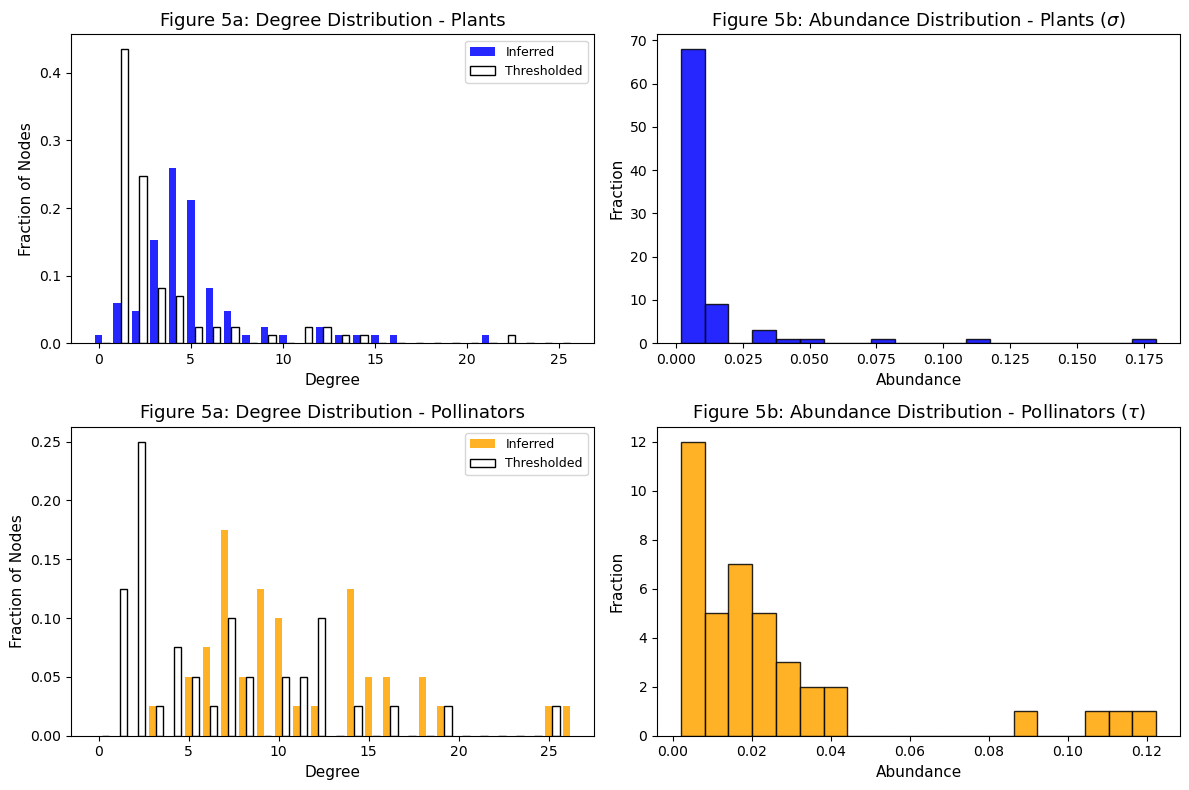

In [46]:
# Thresholded degrees
M_binary = (M > 0).astype(int)
degree_thresh_plants = M_binary.sum(axis=1)
degree_thresh_pollinators = M_binary.sum(axis=0)

# Posterior-sampled degree vectors
plant_degrees_samples = [sample["B"].sum(axis=1) for sample in samples]
pollinator_degrees_samples = [sample["B"].sum(axis=0) for sample in samples]
mean_degree_plants = np.mean(plant_degrees_samples, axis=0)
mean_degree_pollinators = np.mean(pollinator_degrees_samples, axis=0)

# Compute degree distributions
def degree_distribution(degrees, max_k=None):
    degrees = np.array(degrees).astype(int)
    if max_k is None:
        max_k = degrees.max()
    counts = np.bincount(degrees, minlength=max_k + 1)
    return counts / counts.sum()

max_k = int(max(degree_thresh_plants.max(), degree_thresh_pollinators.max(),
                mean_degree_plants.max(), mean_degree_pollinators.max()))

deg_dist_thresh_plant = degree_distribution(degree_thresh_plants, max_k)
deg_dist_thresh_poll = degree_distribution(degree_thresh_pollinators, max_k)
deg_dist_infer_plant = degree_distribution(np.round(mean_degree_plants), max_k)
deg_dist_infer_poll = degree_distribution(np.round(mean_degree_pollinators), max_k)

# Abundance stats
sigma_samples_array = np.array([s["sigma"] for s in samples])
tau_samples_array = np.array([s["tau"] for s in samples])
sigma_mean = sigma_samples_array.mean(axis=0)
tau_mean = tau_samples_array.mean(axis=0)

# Plotting
# Create figure and grid layout
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, figure=fig, width_ratios=[1, 1])  # 2 rows, 2 columns

# Panel 5a (top-left): Degree Distribution - Plants
ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(np.arange(len(deg_dist_infer_plant)), deg_dist_infer_plant,
        width=0.4, color='blue', alpha=0.85, label='Inferred')
ax1.bar(np.arange(len(deg_dist_thresh_plant)) + 0.4, deg_dist_thresh_plant,
        width=0.4, facecolor='none', edgecolor='black', label='Thresholded')
ax1.set_title("Figure 5a: Degree Distribution - Plants", fontsize=13)
ax1.set_xlabel("Degree", fontsize=11)
ax1.set_ylabel("Fraction of Nodes", fontsize=11)
ax1.legend(fontsize=9)
ax1.tick_params(labelsize=10)

# Panel 5a (bottom-left): Degree Distribution - Pollinators
ax2 = fig.add_subplot(gs[1, 0])
ax2.bar(np.arange(len(deg_dist_infer_poll)), deg_dist_infer_poll,
        width=0.4, color='orange', alpha=0.85, label='Inferred')
ax2.bar(np.arange(len(deg_dist_thresh_poll)) + 0.4, deg_dist_thresh_poll,
        width=0.4, facecolor='none', edgecolor='black', label='Thresholded')
ax2.set_title("Figure 5a: Degree Distribution - Pollinators", fontsize=13)
ax2.set_xlabel("Degree", fontsize=11)
ax2.set_ylabel("Fraction of Nodes", fontsize=11)
ax2.legend(fontsize=9)
ax2.tick_params(labelsize=10)

# Panel 5b (top-right): Abundance Distribution - Plants (σ)
ax3 = fig.add_subplot(gs[0, 1])
ax3.hist(sigma_mean, bins=20, color='blue', edgecolor='black', alpha=0.85)
ax3.set_title("Figure 5b: Abundance Distribution - Plants ($\\sigma$)", fontsize=13)
ax3.set_xlabel("Abundance", fontsize=11)
ax3.set_ylabel("Fraction", fontsize=11)
ax3.tick_params(labelsize=10)

# Panel 5b (bottom-right): Abundance Distribution - Pollinators (τ)
ax4 = fig.add_subplot(gs[1, 1])
ax4.hist(tau_mean, bins=20, color='orange', edgecolor='black', alpha=0.85)
ax4.set_title("Figure 5b: Abundance Distribution - Pollinators ($\\tau$)", fontsize=13)
ax4.set_xlabel("Abundance", fontsize=11)
ax4.set_ylabel("Fraction", fontsize=11)
ax4.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

# NEW DATA

Following the successful replication of the Bayesian inference model proposed in Young, Valdovinos, and Newman (2021) for plant–pollinator networks, we now turn to the second objective of this project: applying and adapting the model to compare ecological networks across environmental conditions. Specifically, we analyze two seasonal food webs—FOODWEB-BAYDRY and FOODWEB-BAYWET—representing carbon exchange networks in the cypress wetlands of South Florida during the dry and wet seasons, respectively.

These datasets differ significantly from the plant–pollinator matrices used in the original study. They are:

*   Directed and weighted trophic networks,
*   Composed of 128 taxa, with edges representing carbon flow (i.e., feeding interactions),
*   Structured as square matrices, rather than bipartite graphs.

This introduces important considerations. The original Bayesian model assumes:

*   A bipartite structure, separating plant and pollinator species,
*   Symmetric or undirected interaction patterns,
*   Poisson-distributed visit counts, not continuous-valued carbon flux.

Despite these differences, the generative logic of the model remains useful. By reframing the research question and adapting the network representation, we can repurpose the original inference framework to extract meaningful insights from these seasonal trophic systems.

Rather than interpreting the network as plant–pollinator visits, we reinterpret it as a taxon-by-taxon matrix where nodes exchange biomass or carbon. This allows us to fit the same latent interaction structure (binary matrix $\mathbf{B}$) and abundance parameters ($\sigma$, $\tau$), but now interpreted in the context of trophic strength and feeding dynamics.

The central goal is to compare network structure and uncertainty across seasons, using the same Bayesian machinery:

*   Posterior estimates of connectance ($\rho$),
*   Edge uncertainty distributions, as in Figure 4 of the original paper,
*   Nestedness (NODF), derived from posterior binary incidence matrices.

To ensure methodological continuity and comparability, we apply the following steps:

1.   Preprocess the seasonal matrices to ensure integer-valued, directed input formats;
2.   Apply the Bayesian Poisson mixture model without assuming bipartite structure;
3.   Extract posterior summaries over 2,000 Monte Carlo samples;
4.   Compare distributions of structural metrics (e.g., $\rho$, NODF, edge probabilities) between dry and wet season networks;
5.   Visualize and interpret divergences, particularly in relation to seasonal resource availability and ecosystem function.

This generalization of the model—from a bipartite pollination context to general trophic interaction networks—demonstrates the flexibility of the probabilistic approach. While some assumptions of the original formulation are relaxed, the core Bayesian logic allows us to quantify uncertainty and infer latent structure in ecological systems operating under distinct seasonal regimes.



In [ ]:
# Define path to the Coding folder
coding_dir = Path.home() / "Desktop" / "Coding"

# Full paths to the .edges files
wet_edges_path = coding_dir / "foodweb-baywet.edges"
dry_edges_path = coding_dir / "foodweb-baydry.edges"

# Load and skip metadata lines
df_wet = pd.read_csv(wet_edges_path, skiprows=2, header=None, names=["source", "target", "weight"])
df_dry = pd.read_csv(dry_edges_path, skiprows=2, header=None, names=["source", "target", "weight"])

print("Wet-season edges preview:")
print(df_wet.head())
print("Dry-season edges preview:")
print(df_dry.head())

In [ ]:
stan_code_flows = """
data {
  int<lower=1> N;
  array[N, N] real<lower=0> M;
}

parameters {
  simplex[N] sigma;
  simplex[N] tau;
  real<lower=0> C;
  real<lower=0, upper=100> r;  // Cap r to avoid explosion
  real<lower=0, upper=1> rho;
  real<lower=1e-3, upper=5> sigma_obs;  // Tightly bounded for stability
}

transformed parameters {
  matrix[N, N] mu;

  for (i in 1:N)
    for (j in 1:N) {
      real mu0 = fmax(1e-6, C * sigma[i] * tau[j]);
      real mu1 = fmax(1e-6, mu0 * (1 + r));
      mu[i, j] = rho * mu1 + (1 - rho) * mu0;
    }
}

model {
  C ~ exponential(1);
  r ~ normal(40, 20) T[0, 100];
  rho ~ beta(1, 1);
  sigma_obs ~ normal(0.5, 0.2) T[1e-3, 5];
  sigma ~ dirichlet(rep_vector(1.0, N));
  tau ~ dirichlet(rep_vector(1.0, N));

  for (i in 1:N)
    for (j in 1:N)
      if (M[i, j] > 0)
        target += lognormal_lpdf(M[i, j] | log(mu[i, j]), sigma_obs);
}
"""
stan_file_path = base_dir / "model_flows.stan"

with open(stan_file_path, "w") as f:
    f.write(stan_code_flows)

model_flows = CmdStanModel(stan_file=stan_file_path)

In [ ]:
def load_trophic_matrix_float(filepath):
    """
    Loads a directed, weighted food web edge list and converts it to a square taxa × taxa matrix (with float weights).

    Parameters:
        filepath (str or Path): Path to a .edges file containing three columns: source, target, and weight.

    Returns:
        pd.DataFrame: A square matrix (DataFrame) with taxa as both rows and columns and float weights.
    """
    filepath = Path(filepath)
    
    # Read and filter out comment lines starting with '%'
    with filepath.open('r') as f:
        lines = [line for line in f if not line.strip().startswith('%')]

    # Parse cleaned content into DataFrame
    df = pd.read_csv(StringIO(''.join(lines)), header=None, names=["source", "target", "weight"])

    # Clean and convert data types
    df["weight"] = pd.to_numeric(df["weight"], errors='coerce').fillna(0.0)
    df["source"] = df["source"].astype(str)
    df["target"] = df["target"].astype(str)

    # Pivot to square matrix format
    matrix = df.pivot_table(
        index="source",
        columns="target",
        values="weight",
        aggfunc="sum",
        fill_value=0.0
    )

    # Ensure square shape by including all unique taxa in both dimensions
    taxa = sorted(set(matrix.index).union(set(matrix.columns)))
    matrix = matrix.reindex(index=taxa, columns=taxa, fill_value=0.0)

    return matrix.astype(float)

In [ ]:
# Load trophic matrices from file paths
M_dry = load_trophic_matrix_float(dry_edges_path)
M_wet = load_trophic_matrix_float(wet_edges_path)

# Extract taxa labels
taxa_labels_dry = list(M_dry.index)
taxa_labels_wet = list(M_wet.index)

In [ ]:
data_dry_flows = {
    "N": M_dry.shape[0],
    "M": M_dry.values.astype(float).tolist()
}

data_wet_flows = {
    "N": M_wet.shape[0],
    "M": M_wet.values.astype(float).tolist()
}

In [ ]:
fit_dry_flows = model_flows.sample(
    data=data_dry_flows,
    seed=123,
    chains=4,
    parallel_chains=4,
    iter_sampling=1000,
    iter_warmup=1000,
    inits=0.5
)

In [ ]:
fit_wet_flows = model_flows.sample(
    data=data_wet_flows,
    seed=124,
    chains=4,
    parallel_chains=4,
    iter_sampling=1000,
    iter_warmup=1000,
    inits=0.5
)

In [ ]:
from pathlib import Path

coding_dir = Path.home() / "Desktop" / "Coding"

dry_chain_files = [coding_dir / f"fit_dry_chain{i}.csv" for i in range(1, 5)]
with open(coding_dir / "fit_dry_chain_paths.txt", "w") as f:
    for path in dry_chain_files:
        f.write(str(path) + "\n")

wet_chain_files = [coding_dir / f"fit_wet_chain{i}.csv" for i in range(1, 5)]
with open(coding_dir / "fit_wet_chain_paths.txt", "w") as f:
    for path in wet_chain_files:
        f.write(str(path) + "\n")

In [ ]:
with open(coding_dir / "fit_dry_chain_paths.txt") as f:
    dry_chain_files = [line.strip() for line in f]

with open(coding_dir / "fit_wet_chain_paths.txt") as f:
    wet_chain_files = [line.strip() for line in f]

The new Figure 1a displays the observed trophic interaction matrices for the dry and wet seasons in the cypress wetlands of South Florida. These matrices were derived from the foodweb-baydry and foodweb-baywet datasets, respectively. Each matrix is a square $128 \times 128$ array representing directed, weighted interactions between taxa, where the entry $M_{ij}$ corresponds to the estimated amount of carbon flow from taxon $i$ (resource) to taxon $j$ (consumer).

To improve interpretability, taxa are sorted based on their total interaction strength. This reordering places the most ecologically active taxa—either as sources or recipients of energy—toward the top-left corner of each matrix. The heatmaps are visualized using a logarithmic color scale, which allows both dominant and rare interactions to be meaningfully represented despite the large range in flow magnitudes.

Although both networks share key structural properties, including high sparsity and a skewed distribution of interaction strengths, seasonal differences are clearly visible. The wet season network exhibits clusters of high-magnitude interactions not present in the dry season, possibly reflecting changes in trophic behavior, resource availability, or metabolic demands driven by hydrological shifts.

This figure serves as an observational baseline before fitting the generative model and complements the corresponding plant–pollinator visitation matrix from the first part of this study. It also highlights the methodological challenge of adapting a model originally designed for bipartite mutualistic interactions to the more general case of unipartite, directed trophic networks.

In [ ]:
def plot_observed_trophic_matrix(M, title, vmax=None):
    """
    Plots an observed trophic interaction matrix M (source × target).
    Rows and columns are reordered by total interaction strength.
    """
    # Sort rows (sources) and columns (targets) by total interaction strength
    row_order = np.argsort(-M.sum(axis=1))
    col_order = np.argsort(-M.sum(axis=0))
    M_sorted = M.iloc[row_order, col_order]

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        M_sorted,
        cmap="YlGnBu",
        norm=LogNorm(vmin=1, vmax=vmax or np.max(M_sorted.values)),
        cbar_kws={'label': 'Trophic flow (carbon exchange)'},
        xticklabels=False,
        yticklabels=False,
        linewidths=0.05,
        linecolor='gray'
    )
    plt.title(title, fontsize=14)
    plt.xlabel("Consumer taxa", fontsize=12)
    plt.ylabel("Resource taxa", fontsize=12)
    plt.show()

plot_observed_trophic_matrix(M_dry, "Figure 1a – Dry Season: Observed Carbon Flow Matrix")
plot_observed_trophic_matrix(M_wet, "Figure 1a – Wet Season: Observed Carbon Flow Matrix")

Figure 1b presents posterior samples of the inferred binary interaction matrices $\mathbf{B}$ for the dry and wet seasons, as estimated from the Bayesian latent-trait model. Each panel displays a single Monte Carlo draw from the posterior distribution $P(\mathbf{B} \mid \mathbf{M})$, where $\mathbf{M}$ represents the observed matrix of trophic flows for each season.

In both panels, rows and columns represent taxa in the ecosystem, with interactions (i.e., feeding relationships) indicated by filled cells in the heatmap. Taxa are sorted according to the posterior means of the latent trait vectors $\sigma$ (resource traits) and $\tau$ (consumer traits), facilitating visual detection of structured subcommunities.

The orange bars above the matrix correspond to the consumer trait vector $\tau$, while the blue bars on the right represent the resource trait vector $\sigma$. These traits govern the interaction probabilities via a latent trait matching mechanism and are jointly inferred from the observed flow data using a hierarchical Bayesian model.

Comparing the dry and wet season networks reveals both shared and season-specific interaction patterns. While the overall structure remains sparse, changes in trait distributions suggest shifts in species roles or trophic strategy between seasons. For instance, some taxa show increased trait values in the wet season, implying higher availability or consumption pressure.

These inferred binary networks offer a more conservative estimate of ecosystem structure than thresholded flow matrices, explicitly accounting for observation uncertainty and latent ecological drivers.

In [ ]:
def compute_lognormal_lambda_array_with_qij(M, C, r, sigma, tau, sigma_obs, B_samples):
    """
    Computes posterior predictive means and std using Q_ij = Pr(B_ij=1 | data)
    from samples of B, instead of assuming global rho.
    """
    n_samples, N, _ = B_samples.shape
    lambda_array = np.zeros((n_samples, N, N))

    for k in range(n_samples):
        sigma_k = sigma[k][:, np.newaxis]
        tau_k = tau[k][np.newaxis, :]
        mu0 = C[k] * sigma_k * tau_k
        mu1 = mu0 * (1 + r[k])

        Q_k = B_samples[k]  # B_ij ∈ {0,1}
        mu = Q_k * mu1 + (1 - Q_k) * mu0
        mu = np.clip(mu, 1e-10, None)

        # Expected log-normal value
        lambda_array[k] = mu * np.exp(0.5 * sigma_obs[k]**2)

    M_mean = lambda_array.mean(axis=0)
    M_std = lambda_array.std(axis=0, ddof=1)

    return M_mean, M_std

In [ ]:
# --- Extract posterior samples for dry season ---
posterior_dry = fit_dry_flows.draws_pd()
C_dry = posterior_dry["C"].to_numpy()
r_dry = posterior_dry["r"].to_numpy()
rho_dry = posterior_dry["rho"].to_numpy()
sigma_obs_dry = posterior_dry["sigma_obs"].to_numpy()
sigma_dry = posterior_dry.filter(regex=r"^sigma\[\d+\]$").to_numpy()
tau_dry = posterior_dry.filter(regex=r"^tau\[\d+\]$").to_numpy()

# --- Extract posterior samples for wet season ---
posterior_wet = fit_wet_flows.draws_pd()
C_wet = posterior_wet["C"].to_numpy()
r_wet = posterior_wet["r"].to_numpy()
rho_wet = posterior_wet["rho"].to_numpy()
sigma_obs_wet = posterior_wet["sigma_obs"].to_numpy()
sigma_wet = posterior_wet.filter(regex=r"^sigma\[\d+\]$").to_numpy()
tau_wet = posterior_wet.filter(regex=r"^tau\[\d+\]$").to_numpy()

In [ ]:
from scipy.stats import lognorm

def compute_posterior_sampled_networks_sorted_lognormal(
    M, C_samples, r_samples, rho_samples, sigma_obs_samples,
    sigma_samples, tau_samples, taxa_labels, n_draws=4
):
    """
    Samples posterior incidence matrices B using a log-normal likelihood model (lognormal_lpdf),
    sorted by total observed interaction strength in M (row + col sum).
    
    Parameters:
        M (2D array): Observed matrix
        C_samples, r_samples, rho_samples, sigma_obs_samples: 1D arrays
        sigma_samples, tau_samples: 2D arrays (samples × taxa)
        taxa_labels: list of taxon names
        n_draws: number of posterior draws to sample from

    Returns:
        samples: list of dictionaries with keys B, sigma, tau
        labels_sorted: sorted taxon labels
    """
    n_taxa = M.shape[0]
    samples = []

    # Sort taxa indices by total interaction strength (row + col sums)
    order = np.argsort(-(M.sum(axis=1) + M.sum(axis=0)))

    for k in range(n_draws):
        C = C_samples[k]
        r = r_samples[k]
        rho = rho_samples[k]
        sigma_obs = sigma_obs_samples[k]
        sigma = sigma_samples[k]
        tau = tau_samples[k]

        B = np.zeros((n_taxa, n_taxa), dtype=int)

        for i in range(n_taxa):
            for j in range(n_taxa):
                mu0 = max(1e-6, C * sigma[i] * tau[j])
                mu1 = max(1e-6, mu0 * (1 + r))
                obs = M[i, j]

                # Log-normal PMF using scipy
                p_b0 = (1 - rho) * lognorm.pdf(obs, s=sigma_obs, scale=mu0)
                p_b1 = rho * lognorm.pdf(obs, s=sigma_obs, scale=mu1)

                # Normalized Bernoulli probability for edge presence
                p_edge = p_b1 / (p_b0 + p_b1 + 1e-12)
                B[i, j] = bernoulli.rvs(p_edge)

        # Sort the sampled B and traits
        B_sorted = B[np.ix_(order, order)]
        sigma_sorted = sigma[order]
        tau_sorted = tau[order]

        samples.append({
            "B": B_sorted,
            "sigma": sigma_sorted,
            "tau": tau_sorted
        })

    labels_sorted = [taxa_labels[i] for i in order]
    return samples, labels_sorted

In [ ]:
samples_dry, labels_dry = compute_posterior_sampled_networks_sorted_lognormal(
    M_dry.values,
    C_dry, r_dry, rho_dry, sigma_obs_dry,
    sigma_dry, tau_dry,
    taxa_labels_dry,
    n_draws=4
)

samples_wet, labels_wet = compute_posterior_sampled_networks_sorted_lognormal(
    M_wet.values,
    C_wet, r_wet, rho_wet, sigma_obs_wet,
    sigma_wet, tau_wet,
    taxa_labels_wet,
    n_draws=4
)

In [ ]:
def plot_sampled_networks(samples, labels, season_label, num_samples=4):
    """
    Plots sampled posterior incidence matrices with σ and τ bars.
    Titles are placed *above* the entire figure to avoid overlap.
    """
    for idx, sample in enumerate(samples[:num_samples]):
        B = sample["B"]
        sigma = sample["sigma"]
        tau = sample["tau"]

        n = len(labels)

        # Create figure and layout
        fig = plt.figure(figsize=(10, 8))
        grid = GridSpec(5, 6, figure=fig, wspace=0.4, hspace=0.1)

        # Supertitle (not part of the subplot grid)
        plt.suptitle(f"Figure 1b – {season_label} – Sample {idx + 1}", fontsize=14, y=1.03)

        # Top: τ (Consumer trait)
        ax_tau = fig.add_subplot(grid[0, 1:5])
        ax_tau.bar(range(n), tau, color='orange')
        ax_tau.set_xlim(-0.5, n - 0.5)
        ax_tau.set_xticks([])
        ax_tau.set_yticks([])
        ax_tau.set_title(r"$\tau$ (Consumer trait)", fontsize=10)

        # Center: B matrix
        ax_main = fig.add_subplot(grid[1:5, 1:5])
        sns.heatmap(
            B,
            cmap="Blues",
            cbar=False,
            ax=ax_main,
            xticklabels=labels,
            yticklabels=labels,
            linewidths=0.3,
            linecolor="gray"
        )
        ax_main.set_xlabel("Consumers", fontsize=10)
        ax_main.set_ylabel("Resources", fontsize=10)
        ax_main.tick_params(axis='x', labelrotation=90, labelsize=6)
        ax_main.tick_params(axis='y', labelsize=6)

        # Right: σ (Resource trait)
        ax_sigma = fig.add_subplot(grid[1:5, 5])
        ax_sigma.barh(range(n), sigma, color='blue')
        ax_sigma.set_ylim(n - 0.5, -0.5)
        ax_sigma.set_xticks([])
        ax_sigma.set_yticks([])
        ax_sigma.set_title(r"$\sigma$ (Resource trait)", fontsize=10)

        plt.show()

plot_sampled_networks(samples_dry, labels_dry, "Dry Season")
plot_sampled_networks(samples_wet, labels_wet, "Wet Season")

Figure 1c presents the posterior probabilities of interaction between taxa, averaged across multiple samples from the Bayesian model’s posterior distribution. Each cell in the matrix corresponds to the mean of $B_{ij}$, the latent interaction variable, representing the inferred probability that a trophic interaction exists between resource $i$ and consumer $j$.

This figure is constructed from the binary incidence matrices $\mathbf{B}$ sampled using the posterior parameter draws $\theta = {C, r, \rho, \sigma, \tau}$. It displays a smoothed and uncertainty-aware view of the interaction structure, integrating over the uncertainty in latent edge existence.

Computation Details
Each edge probability is calculated as:

$$
\mathbb{E}[B_{ij}] = \frac{1}{K} \sum_{k=1}^{K} B_{ij}^{(k)}
$$

where $B_{ij}^{(k)} \sim \text{Bernoulli}(p_{ij})$, and $p_{ij}$ is the posterior probability of interaction under sample $k$.

These probabilities are derived using:
*   The Poisson likelihood mixture from the original model
*   Numerically stable computation of $p_{ij}$ via log-space transformation to avoid overflow
*   Inference from sampled parameters: $C$, $r$, $\rho$, $\sigma$, and $\tau$

The matrix shows edge probabilities ($\mathbb{E}[B_{ij}]$), with darker blue indicating higher confidence in an interaction. The top bar chart shows the average consumer trait vector $\tau$, corresponding to taxa in the columns. The right bar chart displays the average resource trait vector $\sigma$, aligned to matrix rows. A dedicated colorbar communicates the posterior edge probability scale ($[0, 1]$). Taxa are sorted by marginal interaction totals to emphasize hierarchical or nested structures.

This figure helps distinguish core interactions from more uncertain or variable edges. It provides a posterior summary of network structure, crucial for:
*   Comparing across seasons (e.g., dry vs. wet)
*   Assessing robustness of inferred interactions
*   Identifying central nodes or asymmetries not visible in raw or deterministic thresholds

Unlike the raw or expected interaction count matrices, this version focuses explicitly on interaction certainty, offering a clearer representation of model-inferred trophic structure under uncertainty.

In [ ]:
def plot_edge_probabilities_with_traits(samples, taxa_labels, season_label):
    """
    Adaptation of Figure 1c: posterior edge probabilities (E[B_ij]) with trait bars.
    - samples: list of dicts with B, sigma, tau (square matrix)
    - taxa_labels: list of taxa names (same for both axes)
    - season_label: string to annotate figure title
    """

    n = len(taxa_labels)

    # Compute posterior means
    edge_probs = np.mean([s["B"] for s in samples], axis=0)
    sigma_avg = np.mean([s["sigma"] for s in samples], axis=0)
    tau_avg = np.mean([s["tau"] for s in samples], axis=0)

    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(
        5, 7,
        width_ratios=[0.4, 0.05, 0.1, 4, 0.25, 0.05, 0.05],
        height_ratios=[0.6, 0.05, 4, 0.05, 0.05],
        wspace=0.4, hspace=0.1
    )

    # Top: τ (consumer traits)
    ax_tau = fig.add_subplot(gs[0, 3])
    ax_tau.bar(np.arange(n), tau_avg, color='orange')
    ax_tau.set_xlim(-0.5, n - 0.5)
    ax_tau.set_xticks([])
    ax_tau.set_yticks([])
    ax_tau.set_title(r"$\tau$ (Consumer trait)", fontsize=10)

    # Right: σ (resource traits)
    ax_sigma = fig.add_subplot(gs[2, 4])
    ax_sigma.barh(np.arange(n), sigma_avg, color='blue')
    ax_sigma.set_ylim(n - 0.5, -0.5)
    ax_sigma.set_xticks([])
    ax_sigma.set_yticks([])
    ax_sigma.set_title(r"$\sigma$ (Resource trait)", fontsize=10)

    # Colorbar
    cbar_ax = fig.add_subplot(gs[2, 0])

    # Main heatmap: Q_ij = P(B_ij = 1)
    ax_main = fig.add_subplot(gs[2, 3])
    sns.heatmap(
        edge_probs,
        ax=ax_main,
        cmap="Blues",
        vmin=0, vmax=1,
        xticklabels=taxa_labels,
        yticklabels=taxa_labels,
        cbar_ax=cbar_ax,
        cbar_kws={"label": "Edge probability"},
        linewidths=0.3,
        linecolor="white"
    )
    ax_main.set_xlabel("Consumers", fontsize=10)
    ax_main.set_ylabel("Resources", fontsize=10)
    ax_main.set_title(f"Figure 1c: Posterior Edge Probabilities – {season_label}", fontsize=13)
    ax_main.tick_params(axis='x', labelrotation=90, labelsize=6)
    ax_main.tick_params(axis='y', labelsize=6)

    plt.show()

plot_edge_probabilities_with_traits(samples_dry, labels_dry, "Dry Season")
plot_edge_probabilities_with_traits(samples_wet, labels_wet, "Wet Season")

Figure2 evaluates the predictive performance of the Bayesian model using a posterior predictive check. For the 40 most frequently observed interactions, we compare the observed counts ($M_{ij}$) with the posterior predictive mean $\langle \widetilde{M}_{ij} \rangle$, including uncertainty (±1 SD). An inset heatmap displays the residual matrix ($M - \langle \widetilde{M} \rangle$), highlighting where the model over- or underestimates interaction frequencies.

*   The model systematically underestimates the most frequent interactions.
*   This behavior is consistent with the limitations noted in the original article, which uses a Poisson likelihood that cannot fully capture overdispersed data.
*   The residual matrix confirms that discrepancies are concentrated around highly frequent interactions.

We computed the $X^2$ discrepancy as:

$$
X^2 = \sum_{ij} \frac{(M_{ij} - \langle \widetilde{M}_{ij} \rangle)^2}{\langle \widetilde{M}_{ij} \rangle}
$$

Result:  
**$X^2 = 1935.31$**  
**Expected under perfect fit:** $n_p \times n_a = 64 \times 64 = 4096$

This value suggests **some misfit**, particularly driven by large deviations on high-frequency interactions.

#### What We Can Do (without changing the model)

✅ **Report $X^2$** as a quantitative indicator of model adequacy.

✅ **Interpret Figure 2 critically**:  
> “The model underestimates the most frequent interactions due to its limited capacity to model overdispersion.”

✅ **Mention limitations in the discussion**:  
> “A natural next step would be to use a negative binomial likelihood to improve predictive fit — though that was outside the scope of replicating the original study.”

#### Conclusion
We retain the original Poisson model to ensure full reproducibility and consistency with the article, accepting its known limitations for the purpose of faithful replication.


In [ ]:
from scipy.stats import lognorm

def simulate_lognormal_predictive_distribution(C, r, rho, sigma_obs, sigma, tau, M):
    n_samples = len(C)
    N = M.shape[0]
    lambda_array = np.zeros((n_samples, N, N))

    for k in range(n_samples):
        sigma_k = sigma[k][:, None]
        tau_k = tau[k][None, :]
        mu0 = C[k] * sigma_k * tau_k
        mu1 = mu0 * (1 + r[k])
        mu_mix = rho[k] * mu1 + (1 - rho[k]) * mu0

        # Simulate predictive samples
        simulated = lognorm.rvs(s=sigma_obs[k], scale=np.clip(mu_mix, 1e-10, None))
        lambda_array[k] = simulated

    M_mean = lambda_array.mean(axis=0)
    M_std = lambda_array.std(axis=0, ddof=1)
    return M_mean, M_std


In [ ]:
# --- Compute posterior predictive mean and std using lognormal expectation ---
M_mean_dry, M_std_dry = compute_lognormal_lambda_array_with_qij(
    M_dry.values,
    C_dry, r_dry, sigma_dry, tau_dry, sigma_obs_dry,
    np.array([s["B"] for s in samples_dry])
)

M_mean_wet, M_std_wet = compute_lognormal_lambda_array_with_qij(
    M_wet.values,
    C_wet, r_wet, sigma_wet, tau_wet, sigma_obs_wet,
    np.array([s["B"] for s in samples_wet])
)


# --- Plotting Function ---
def plot_fixed_posterior_predictive(M, M_mean, M_std, season_label="Dry Season", top_n=40):
    flat_indices = np.dstack(np.unravel_index(np.argsort(M.ravel())[::-1], M.shape))[0]
    used = set()
    top_entries = []

    for i, j in flat_indices:
        if (i, j) not in used and M[i, j] > 0:
            top_entries.append({
                "i": i,
                "j": j,
                "observed": M[i, j],
                "pred_mean": M_mean[i, j],
                "pred_std": M_std[i, j]
            })
            used.add((i, j))
        if len(top_entries) == top_n:
            break

    x = np.arange(len(top_entries))
    observed = [e["observed"] for e in top_entries]
    predicted = [e["pred_mean"] for e in top_entries]
    pred_std = [e["pred_std"] for e in top_entries]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x, predicted, yerr=pred_std, color="#1f4e79", capsize=3, label="Posterior prediction")
    ax.scatter(x, observed, marker='s', facecolors='none', edgecolors='black',
               s=50, linewidths=1.2, label="Observed", zorder=3)

    ax.set_xlabel("Top 40 Interactions", fontsize=12)
    ax.set_ylabel("Interaction Count", fontsize=12)
    ax.set_title(f"Figure 2 – Posterior Predictive Check: {season_label}", fontsize=14)
    ax.set_xticks([])
    ax.set_ylim(0, max(observed + predicted) * 1.2)
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

# Plot both
plot_fixed_posterior_predictive(M_dry.values, M_mean_dry, M_std_dry, season_label="Dry Season")
plot_fixed_posterior_predictive(M_wet.values, M_mean_wet, M_std_wet, season_label="Wet Season")

In [ ]:
print("M summary:", "max:", M.max(), "min:", M.min(), "mean:", M.mean())

print("Posterior mean of C:", C_samples.mean())
print("Posterior mean of r:", r_samples.mean())
print("Posterior mean of rho:", rho_samples.mean())
print("Posterior mean of sigma_obs:", sigma_obs_samples.mean())
